# 0. Prepare Environment 

In [9]:
import dimcli
import numpy as np
import pandas as pd

import country_converter as coco 
import pycountry

import re
import typing
from ast import literal_eval
from typing import Iterable

# import dataframe_image as dfi
import dimcli
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.impute import SimpleImputer

from fuzzywuzzy import fuzz

/Users/chenyuli/anaconda3/envs/py3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# dimcli.login(
#     key="", endpoint="https://app.dimensions.ai"
# )
dsl = dimcli.Dsl()

get_new_data = False

# 1. Data Pre-processing 

### Get Data 

In [5]:
def get_split(ser: pd.Series):
    return np.array_split(ser, ser.shape[0] / 400)


def get_data():
    if get_new_data:
        control = pd.read_csv("control-pmid.csv")
        """Query:
        https://pubmed.ncbi.nlm.nih.gov/?term=%28%28%22machine+learning%22%5BMajr%5D+OR+%28%22machine%22%5Bti%5D+AND+%22learning%22%5Bti%5D%29+OR+%22machine+learning%22%5Bti%5D+OR+%22AI%22%5Bti%5D+OR+%22Artificial+Intelligence%22%5Bti%5D+OR+%22artificially+intelligent%22%5Bti%5D+OR+%22Artificial+Intelligence%22%5BMeSH%5D+OR+%22Algorithms%22%5BMeSH%5D+OR+%22algorithm*%22%5Bti%5D+OR+%22deep+learning%22%5Bti%5D+OR+%22computer+vision%22%5Bti%5D+OR+%22natural+language+processing%22%5Bti%5D+OR+%22neural+network*%22%5Bti%5D+OR+%22neural+networks%2C+computer%22%5BMeSH%5D+OR+%22intelligent+machine*%22%5Bti%5D%29+AND+%28exp+%22Intensive+Care+Units%22%2F+OR+exp+%22Critical+Care%22%2F+OR+%28ICU+OR+IC+OR+%28%28intensive+OR+critical%29+ADJ3+%28care+OR+therapy+OR+unit*+OR+patient*+OR+department%5C*%29%29%29%29%29&filter=years.2010-2023
        """
        df_pubs_control = pd.DataFrame()
        df_auths_control = pd.DataFrame()
        df_affils_control = pd.DataFrame()

        for pmid_list in get_split(control.PMID):
            query = fr"""search publications where pmid in {list(pmid_list)} and year in [2010:2022]
            return publications[basics+abstract+authors_count+doi+concepts_scores+times_cited+mesh_terms
            +journal+editors+field_citation_ratio+funder_countries+funders+open_access
            +relative_citation_ratio+publisher+pmid+supporting_grant_ids+research_org_cities+pmid
            +research_org_countries+research_org_country_names+research_org_names+research_org_state_codes
            +research_org_state_names+research_orgs+researchers+category_bra+category_for+category_hra+category_hrcs_hc+
            category_hrcs_rac+category_icrp_cso+category_icrp_ct+category_rcdc+category_sdg+category_uoa]"""
            data = dsl.query_iterative(query)
            df_pubs_control = pd.concat([df_pubs_control, data.as_dataframe()])
            df_auths_control = pd.concat(
                [df_auths_control, data.as_dataframe_authors()]
            )
            df_affils_control = pd.concat(
                [df_affils_control, data.as_dataframe_authors_affiliations()]
            )

        df_pubs_control.to_csv("control_group_pubs.csv")
        df_auths_control.to_csv("control_group_auths.csv")
        df_affils_control.to_csv("control_group_affils.csv")

        compare_query = fr"""search publications where year in [2010:2022] for "\"datamed org display item php\" OR \"physionet mimic ii database\" 
        OR \"mimic iii medical information mart for intensive care\" OR
        \"10.13026 s6n6 xd98\" OR \"mimic iv\" OR \"physionet org content mimiciv\" OR
        \"eicu crd\" OR \"mimic cxr\"" return publications[basics+abstract+authors_count+doi+concepts_scores+times_cited
            +mesh_terms+journal+editors+field_citation_ratio+funder_countries+funders+open_access
            +relative_citation_ratio+publisher+pmid+supporting_grant_ids+research_org_cities+pmid
            +research_org_countries+research_org_country_names+research_org_names+research_org_state_codes
            +research_org_state_names+research_orgs+researchers+category_bra+category_for+category_hra+category_hrcs_hc+
            category_hrcs_rac+category_icrp_cso+category_icrp_ct+category_rcdc+category_sdg+category_uoa]"""
        compare = dsl.query_iterative(compare_query)

        df_pubs_compare = compare.as_dataframe()
        df_auths_compare = compare.as_dataframe_authors()
        df_affils_compare = compare.as_dataframe_authors_affiliations()

        df_pubs_compare.to_csv("mimic_pubs.csv")
        df_auths_compare.to_csv("mimic_auths.csv")
        df_affils_compare.to_csv("mimic_affils.csv")

    else:
        df_pubs_compare = pd.read_csv("./MIMIC_Files/mimic_pubs.csv")
        df_auths_compare = pd.read_csv("./MIMIC_Files/mimic_auths.csv")
        df_affils_compare = pd.read_csv("./MIMIC_Files/mimic_affils.csv")

        df_pubs_control = pd.read_csv("./MIMIC_Files/control_group_pubs.csv")
        df_auths_control = pd.read_csv("./MIMIC_Files/control_group_auths.csv")
        df_affils_control = pd.read_csv("./MIMIC_Files/control_group_affils.csv")

    return (
        df_pubs_compare,
        df_auths_compare,
        df_affils_compare,
        df_pubs_control,
        df_auths_control,
        df_affils_control,
    )

In [6]:
(
    df_pubs_compare,
    df_auths_compare,
    df_affils_compare,
    df_pubs_control,
    df_auths_control,
    df_affils_control,
) = get_data()

In [7]:
test_compare_pubs = pd.read_csv("./MIMIC_Files/mimic_pubs.csv")
print(len(test_compare_pubs))

2307


#### preprocessing pipeline
need data _name_genderize_output (1).csv 

In [9]:
df_gender_dictionary = pd.read_csv("_name_genderize_output (1).csv") ### check dataset 
df_gender_dictionary.drop_duplicates("ga_first_name", inplace=True)
df_gender_dictionary.set_index("ga_first_name", inplace=True)


CountryClass = pd.read_excel("CountryClassWordBank (1).xlsx")
CountryClass_2 = CountryClass.copy()
CountryClass_2.set_index("Code", inplace=True)
missing_codes = []


gender_dict = dict(zip(df_gender_dictionary.index, df_gender_dictionary.ga_gender))
country_dict = dict(zip(CountryClass_2.index, CountryClass_2["Income group"]))
gender_map = {"male": 0, "female": 1, "unknown": np.nan}
income_map = {
    "High income": 4,
    "Upper middle income": 3,
    "Lower middle income": 2,
    "Low income": 1,
}


def get_gender(name):
    if pd.isna(name):
        return np.nan
    name = name.strip()
    name = name.split(sep=" ")[0]
    if name in gender_dict:
        return gender_dict[name]
    else:
        return np.nan


def get_gender_ints(gender):
    if gender in gender_map:
        return gender_map[gender]
    else:
        return np.nan


def get_country_income(country_code):
    if pd.isna(country_code):
        return np.nan
    country_ISO3 = pycountry.countries.get(alpha_2=country_code)
    if country_ISO3 is None:
        missing_codes.append(country_code)
        return np.nan
    elif country_ISO3.alpha_3 in country_dict:
        return country_dict[country_ISO3.alpha_3]
    else:
        missing_codes.append(country_code)
        return np.nan


def map_country_income(income_group):
    if income_group in income_map:
        return income_map[income_group]
    else:
        return np.nan


def get_pub_year(pub_id, df_pubs):
    return df_pubs.at[pub_id, "year"]


def categorize_author_counts(num_authors):
    if pd.isna(num_authors) or num_authors == 0:
        return np.nan
    if num_authors == 1:
        return "1"
    if num_authors == 2:
        return "2"
    if num_authors >= 3 and num_authors <= 5:
        return "3-5"
    if num_authors >= 6:
        return "6+"
    return np.nan


def pipeline(list_of_dataframes: list):
    df_pubs, df_auths, df_affils = list_of_dataframes
    df_pubs_copy = df_pubs.copy()
    df_pubs_copy.set_index("id", inplace=True)

    df_auths["year"] = df_auths["pub_id"].apply(
        lambda pid: get_pub_year(pid, df_pubs_copy)
    )
    df_affils["year"] = df_affils["pub_id"].apply(
        lambda pid: get_pub_year(pid, df_pubs_copy)
    )

    df_auths["first_name"] = df_auths["first_name"].str.title()
    df_affils["first_name"] = df_affils["first_name"].str.title()

    df_auths["gender"] = df_auths["first_name"].map(get_gender)
    df_affils["gender"] = df_affils["first_name"].map(get_gender)

    df_auths["gender_ints"] = df_auths["gender"].map(get_gender_ints)
    df_affils["gender_ints"] = df_affils["gender"].map(get_gender_ints)

    df_pubs["author_count_categories"] = df_pubs["authors_count"].apply(
        categorize_author_counts
    )

    lfirstnames = dict.fromkeys(df_pubs.id, np.nan)
    lgenders = dict.fromkeys(df_pubs.id, np.nan)
    lpctfemale = dict.fromkeys(df_pubs.id, np.nan)
    lffirst = dict.fromkeys(df_pubs.id, np.nan)
    lflast = dict.fromkeys(df_pubs.id, np.nan)
    lnfemale = dict.fromkeys(df_pubs.id, np.nan)
    lnmale = dict.fromkeys(df_pubs.id, np.nan)
    lnnan = dict.fromkeys(df_pubs.id, np.nan)

    for pub_id, df_info in df_auths.groupby("pub_id"):
        lfirstnames[pub_id] = df_info["first_name"]
        lgenders[pub_id] = df_info["gender_ints"]

        genders = df_info["gender_ints"]

        lffirst[pub_id] = genders.iloc[0]
        lflast[pub_id] = genders.iloc[-1]

        num_female = (genders == 1).sum()
        num_male = (genders == 0).sum()
        num_missing = genders.isna().sum()
        lnfemale[pub_id] = num_female  
        lnmale[pub_id] = num_male 
        lnnan[pub_id] = num_missing  
        total = num_male + num_female
        if total == 0:
            lpctfemale[pub_id] = np.nan
        else:
            lpctfemale[pub_id] = num_female / total

    df_pubs["first_names"] = lfirstnames.values()
    df_pubs["genders"] = lgenders.values()
    df_pubs["num_female"] = lnfemale.values()
    df_pubs["num_male"] = lnmale.values()
    df_pubs["num_na"] = lnnan.values()
    df_pubs["pct_female_real"] = lpctfemale.values()
    df_pubs["female_first"] = lffirst.values()
    df_pubs["female_last"] = lflast.values()

    cols = ["num_female", "num_male", "num_na"]
    total = df_pubs[cols[0]] + df_pubs[cols[1]] + df_pubs[cols[2]]
    df_pubs["pct_female_pessimistic"] = df_pubs[cols[0]] / total
    df_pubs["pct_female_optimistic"] = (df_pubs[cols[0]] + df_pubs[cols[2]]) / total
    df_pubs["female_first_pessimistic"] = df_pubs["female_first"].apply(
        lambda x: 0 if pd.isna(x) else x
    )
    df_pubs["female_first_optimistic"] = df_pubs["female_first"].apply(
        lambda x: 1 if pd.isna(x) else x
    )
    df_pubs["female_last_pessimistic"] = df_pubs["female_last"].apply(
        lambda x: 0 if pd.isna(x) else x
    )
    df_pubs["female_last_optimistic"] = df_pubs["female_last"].apply(
        lambda x: 1 if pd.isna(x) else x
    )

    df_affils["income_class"] = df_affils["aff_country_code"].apply(get_country_income)
    df_affils["income_class_num"] = df_affils["income_class"].map(map_country_income)

    return [df_pubs, df_auths, df_affils]

FileNotFoundError: [Errno 2] No such file or directory: '_name_genderize_output (1).csv'

# 1. Gender Analysis

In [10]:
df_auths_compare.head()

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id,year,gender,gender_ints
0,0,[],NaN,NaN,Feng,Shen,[],[],NaN,pub.1154752616,2022,male,0.0
1,1,[],NaN,NaN,Qimin,CHEN,[],[],NaN,pub.1154752616,2022,female,1.0
2,2,[],NaN,NaN,Wei,Li,[],[],NaN,pub.1154752616,2022,male,0.0
3,3,[],NaN,NaN,Ying,Wang,[],[],NaN,pub.1154752616,2022,female,1.0
4,4,[],NaN,NaN,Xianjun,CHEN,[],[],NaN,pub.1154752616,2022,male,0.0


In [12]:
# Filter the DataFrame to show only non-duplicated records based on 'first_name' and 'last_name'.
non_duplicated_authors_compare = df_auths_compare[~df_auths_compare[['first_name', 'last_name','researcher_id']].duplicated()]
non_duplicated_authors_control = df_auths_control[~df_auths_control[['first_name', 'last_name','researcher_id']].duplicated()]


In [13]:
print("Compare distinct author names ",len(non_duplicated_authors_compare))
print("Control distinct author names ",len(non_duplicated_authors_control))
print("Compare distinct author names with gender not none ",len(non_duplicated_authors_compare[non_duplicated_authors_compare.gender.notna()]))
print("Control distinct author names with gender not none",len(non_duplicated_authors_control[non_duplicated_authors_control.gender.notna()]))
print("Compare distinct author names -female",len(non_duplicated_authors_compare[non_duplicated_authors_compare.gender=='female']))
print("Control distinct author names -female",len(non_duplicated_authors_control[(non_duplicated_authors_control.gender=='female')]))
print(2438/8758)
print(4710/15285)



Compare distinct author names  9959
Control distinct author names  17999
Compare distinct author names with gender not none  8758
Control distinct author names with gender not none 15285
Compare distinct author names -female 2438
Control distinct author names -female 4710
0.2783740580041105
0.30814524043179586


In [ ]:
print(len(df_auths_compare.pub_id.unique()))
print(len(df_auths_control.pub_id.unique()))

2197
2910


In [16]:
def get_missingness(df_pubs, df_auths, df_affils):
    df_completeness = pd.DataFrame()
    df_completeness["id"] = df_pubs["id"]

    df_completeness["Publications"] = True
    df_completeness["Authors"] = df_pubs.id.isin(df_auths.pub_id)
    df_completeness["Affiliations"] = df_pubs.id.isin(df_affils.pub_id)

    df_completeness.head()
    print(f"Total numbers of publications:   {len(df_completeness)}")
    print(f"Papers w/ Missing Publications:   0")
    print(
        f"Papers w/ Missing Authors:        {df_completeness.Authors.value_counts()[False]}"
    )
    print(
        f"Papers w/ Missing Affiliations:   {df_completeness.Affiliations.value_counts()[False]}"
    )

    return df_completeness  # df_completeness


print("Compare")
df_complete_compare = get_missingness(df_pubs_compare, df_auths_compare, df_affils_compare)
print()
print("Control")
df_complete_control = get_missingness(df_pubs_control, df_auths_control, df_affils_control)

Compare
Total numbers of publications:   2307
Papers w/ Missing Publications:   0
Papers w/ Missing Authors:        110
Papers w/ Missing Affiliations:   635

Control
Total numbers of publications:   2912
Papers w/ Missing Publications:   0
Papers w/ Missing Authors:        2
Papers w/ Missing Affiliations:   35


In [17]:
df_complete_compare.Authors.value_counts()

Authors
True     2197
False     110
Name: count, dtype: int64

In [18]:
print("Compare missing Affiliation percentage",635/2307)
print("Control missing Affiliation percentage",35/2912)



Compare missing Affiliation percentage 0.2752492414390984
Control missing Affiliation percentage 0.01201923076923077


In [19]:
num_compare_auths = df_auths_compare.shape[0]
num_control_auths = df_auths_control.shape[0]
num_total_auths = num_compare_auths + num_control_auths

print(
    f"Compare group authors: {num_compare_auths}. Pct: {num_compare_auths / num_total_auths}"
)
print(
    f"Control group authors: {num_control_auths}. Pct: {num_control_auths / num_total_auths}"
)
print(f"Total:                 {num_total_auths}")

Compare group authors: 13879. Pct: 0.40324830030797837
Control group authors: 20539. Pct: 0.5967516996920216
Total:                 34418


In [ ]:
print(df_pubs_compare['genders'].head())

0    0     0.0\n1     1.0\n2     0.0\n3     1.0\n4 ...
1    11    0.0\n12    1.0\n13    1.0\n14    1.0\n15...
2    18    1.0\n19    NaN\nName: gender_ints, dtype...
3    20    0.0\n21    0.0\n22    0.0\n23    1.0\nNa...
4                                                  NaN
Name: genders, dtype: object


In [20]:
df_pubs_compare.columns
df_pubs_compare.researchers[1]

"[{'first_name': 'Xiaxuan', 'id': 'ur.014116573320.23', 'last_name': 'Huang', 'research_orgs': ['grid.412601.0']}, {'first_name': 'Shi-Qi', 'id': 'ur.016241001520.36', 'last_name': 'Yuan', 'orcid_id': ['0000-0002-2794-2546'], 'research_orgs': ['grid.484195.5', 'grid.413107.0', 'grid.412601.0']}, {'first_name': 'Yitong', 'id': 'ur.013553641416.27', 'last_name': 'Ling', 'research_orgs': ['grid.412601.0']}, {'first_name': 'Shanyuan', 'id': 'ur.014351222016.81', 'last_name': 'Tan', 'research_orgs': ['grid.412601.0']}, {'first_name': 'Tao', 'id': 'ur.014227217615.79', 'last_name': 'Huang', 'orcid_id': ['0000-0002-7645-4290'], 'research_orgs': ['grid.256922.8', 'grid.412601.0']}, {'first_name': 'Hongtao', 'id': 'ur.012755055514.47', 'last_name': 'Cheng', 'orcid_id': ['0000-0003-3739-9097'], 'research_orgs': ['grid.258164.c']}, {'first_name': 'Jun', 'id': 'ur.012157101103.38', 'last_name': 'Lyu', 'orcid_id': ['0000-0002-2237-8771'], 'research_orgs': ['grid.440588.5', 'grid.452438.c', 'grid.25

In [21]:
df_pubs_compare[df_pubs_compare['genders'].notna()]['genders']

0       0     0.0\n1     1.0\n2     0.0\n3     1.0\n4 ...
1       11    0.0\n12    1.0\n13    1.0\n14    1.0\n15...
2       18    1.0\n19    NaN\nName: gender_ints, dtype...
3       20    0.0\n21    0.0\n22    0.0\n23    1.0\nNa...
5       24    1.0\n25    1.0\n26    0.0\n27    NaN\n28...
                              ...                        
2302    13865   NaN\n13866   NaN\n13867   NaN\n13868  ...
2303    13870    0.0\n13871    0.0\nName: gender_ints,...
2304    13872    0.0\n13873    NaN\n13874    0.0\nName...
2305    13875   NaN\n13876   NaN\n13877   NaN\nName: g...
2306      13878    0.0\nName: gender_ints, dtype: float64
Name: genders, Length: 2197, dtype: object

In [22]:
print("MIMIC paper/gender not missing ",len(df_pubs_compare)-df_pubs_compare['genders'].isna().sum())
print("Control paperw/gender not missing", len(df_pubs_control)-df_pubs_control['genders'].isna().sum())


MIMIC paper/gender not missing  2197
Control paperw/gender not missing 2910


In [23]:
num_compare = df_pubs_compare.shape[0]
num_control = df_pubs_control.shape[0]
num_total = num_compare + num_control

print(f"Compare group papers: {num_compare}. Pct: {num_compare / num_total}")
print(f"Control group papers: {num_control}. Pct: {num_control / num_total}")
print(f"Total:                {num_total}")

Compare group papers: 2307. Pct: 0.4420387047327074
Control group papers: 2912. Pct: 0.5579612952672925
Total:                5219


In [24]:
num_compare_auths = df_auths_compare.shape[0]
num_control_auths = df_auths_control.shape[0]
num_total_auths = num_compare_auths + num_control_auths

print(
    f"Compare group authors: {num_compare_auths}. Pct: {num_compare_auths / num_total_auths}"
)
print(
    f"Control group authors: {num_control_auths}. Pct: {num_control_auths / num_total_auths}"
)
print(f"Total:                 {num_total_auths}")

Compare group authors: 13879. Pct: 0.40324830030797837
Control group authors: 20539. Pct: 0.5967516996920216
Total:                 34418


In [26]:
def process(df_pubs, df_auths, df_affils):
    # Get rid of papers with missing genders
    pubs = df_pubs[df_pubs.num_na == 0]
    auths = df_auths[df_auths.pub_id.isin(pubs.id)]  
    ##### what if the author has multiple pub_ids and cannot be catched to one pubid? 
    affils = df_affils[df_affils.pub_id.isin(pubs.id)]
    return pubs, auths, affils


def print_col(col):
    print(col)
    print()
    print("Compare:")
    print(df_pubs_compare[col].describe())
    print()
    print("Control:")
    print(df_pubs_control[col].describe())
    print()
def print_col_processed(col):
    print(col)
    print()
    print("Compare:")
    print(df_pubs_compare_processed[col].describe())
    print()
    print("Control:")
    print(df_pubs_control_processed[col].describe())
    print()

df_pubs_compare_processed, df_auths_compare_processed, df_affils_compare_processed = process(
    df_pubs_compare, df_auths_compare, df_affils_compare
)

df_pubs_control_processed, df_auths_control_processed, df_affils_control_processed = process(
    df_pubs_control, df_auths_control, df_affils_control
)

print_col("pct_female_real")
print_col("female_first")
print_col("female_last")
print_col_processed("pct_female_real")
print_col_processed("female_first")
print_col_processed("female_last")

pct_female_real

Compare:
count    2118.000000
mean        0.262372
std         0.233256
min         0.000000
25%         0.000000
50%         0.250000
75%         0.400000
max         1.000000
Name: pct_female_real, dtype: float64

Control:
count    2666.000000
mean        0.281781
std         0.252491
min         0.000000
25%         0.000000
50%         0.250000
75%         0.444444
max         1.000000
Name: pct_female_real, dtype: float64

female_first

Compare:
count    1939.000000
mean        0.279010
std         0.448628
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: female_first, dtype: float64

Control:
count    2449.000000
mean        0.308289
std         0.461881
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: female_first, dtype: float64

female_last

Compare:
count    1948.000000
mean        0.232546
std         0.422564
min         0.000000
25%  

In [27]:
df_affils_compare_processed.groupby("pub_id").count()

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,researcher_id,first_name,last_name,year,gender,gender_ints,income_class,income_class_num
pub_id,,,,,,,,,,,,,,,,,,
pub.1001792778,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3
pub.1003040860,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
pub.1006639384,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
pub.1008209435,5,5,5,5,5,5,5,5,3,3,5,5,5,5,5,5,5,5
pub.1011872206,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pub.1155035716,7,7,7,7,7,7,7,7,0,0,6,7,7,7,7,7,7,7
pub.1155035818,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
pub.1155035834,3,3,3,3,3,2,3,3,2,1,3,3,3,3,3,3,3,3


In [28]:
df_auths_compare_processed.groupby("pub_id").count()

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,year,gender,gender_ints
pub_id,,,,,,,,,,,,
pub.1001792778,3,3,1,2,3,3,3,3,2,3,3,3
pub.1003040860,1,1,1,0,1,1,0,1,1,1,1,1
pub.1006639384,3,3,1,3,3,3,0,3,3,3,3,3
pub.1008209435,1,1,0,1,1,1,0,1,1,1,1,1
pub.1011872206,2,2,1,2,2,2,0,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
pub.1155035716,7,7,1,6,7,7,3,7,6,7,7,7
pub.1155035818,6,6,1,6,6,6,3,6,6,6,6,6
pub.1155035834,3,3,1,3,3,3,2,3,3,3,3,3


In [29]:
# df_pubs_compare.num_na==NaN
pub_ids_num0 = df_pubs_compare[df_pubs_compare.num_na==0].id
print(pub_ids_num0)

0       pub.1154752616
1       pub.1154144039
3       pub.1154113975
8       pub.1154169122
9       pub.1154026246
             ...      
2298    pub.1016021216
2299    pub.1095060035
2301    pub.1013870421
2303    pub.1012760885
2306    pub.1008209435
Name: id, Length: 1426, dtype: object


In [30]:
df_pubs_compare['authors'] # 'pub.1154752616'
# print(df_pubs_compare[df_pubs_compare.id =='pub.1154752616'].get('authors'))
print(df_pubs_compare[df_pubs_compare['authors']==df_pubs_compare['authors'][1]].id)
id = df_pubs_compare[df_pubs_compare['authors']==df_pubs_compare['authors'][1]].id.iloc[0]
# print(id.iloc[0])
print(df_pubs_compare[df_pubs_compare.id ==id].get('authors'))
print(df_affils_compare[df_affils_compare.pub_id==id])

1    pub.1154144039
Name: id, dtype: object
1    [{'affiliations': [{'city': 'Guangzhou', 'city...
Name: authors, dtype: object
   Unnamed: 0   aff_city  aff_city_id aff_country aff_country_code  \
0           0  Guangzhou    1809858.0       China               CN   
1           1  Guangzhou    1809858.0       China               CN   
2           2  Guangzhou    1809858.0       China               CN   
3           3  Guangzhou    1809858.0       China               CN   
4           4  Guangzhou    1809858.0       China               CN   
5           5  Guangzhou    1809858.0       China               CN   
6           6  Guangzhou    1809858.0       China               CN   

          aff_id                                       aff_name  \
0  grid.412601.0  First Affiliated Hospital of Jinan University   
1  grid.412601.0  First Affiliated Hospital of Jinan University   
2  grid.412601.0  First Affiliated Hospital of Jinan University   
3  grid.412601.0  First Affiliated Hospital

In [31]:
df_pubs_compare[df_pubs_compare.id.isin(pub_ids_num0)]

,Unnamed: 0,id,title,abstract,authors,authors_count,category_for,category_hra,category_hrcs_hc,category_hrcs_rac,...,num_na,pct_female_real,female_first,female_last,pct_female_pessimistic,pct_female_optimistic,female_first_pessimistic,female_first_optimistic,female_last_pessimistic,female_last_optimistic
0,0,pub.1154752616,The U-shaped impact of mean arterial pressure ...,<sec> BACKGROUND <p>Sepsis is a major cause of...,"[{'affiliations': [], 'corresponding': '', 'cu...",11,"[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '903', 'name': 'Inflammatory and immun...","[{'id': '10204', 'name': '2.4 Surveillance and...",...,0.0,0.454545,0.0,1.0,0.454545,0.454545,0.0,0.0,1.0,1.0
1,1,pub.1154144039,The Hemoglobin-to-Red Cell Distribution Width ...,Objective: The hemoglobin-to-red cell distribu...,"[{'affiliations': [{'city': 'Guangzhou', 'city...",7,"[{'id': '80003', 'name': '32 Biomedical and Cl...",NaN,NaN,NaN,...,0.0,0.428571,0.0,0.0,0.428571,0.428571,0.0,0.0,0.0,0.0
3,3,pub.1154113975,Prediction and risk assessment of sepsis-assoc...,Sepsis-associated encephalopathy (SAE) is a ma...,"[{'affiliations': [{'city': 'Beijing', 'city_i...",4,"[{'id': '80017', 'name': '46 Information and C...",NaN,NaN,NaN,...,0.0,0.250000,0.0,1.0,0.250000,0.250000,0.0,0.0,1.0,1.0
8,8,pub.1154169122,Multimodal Explainability via Latent Shift app...,We are witnessing a widespread adoption of art...,"[{'affiliations': [], 'corresponding': '', 'cu...",7,"[{'id': '80017', 'name': '46 Information and C...",NaN,NaN,NaN,...,0.0,0.285714,0.0,0.0,0.285714,0.285714,0.0,0.0,0.0,0.0
9,9,pub.1154026246,The correlation study between blood urea nitro...,BackgroundSepsis is a common critical illness ...,"[{'affiliations': [{'city': 'Huzhou', 'city_id...",5,"[{'id': '80003', 'name': '32 Biomedical and Cl...","[{'id': '3901', 'name': 'Clinical'}]","[{'id': '903', 'name': 'Inflammatory and immun...",NaN,...,0.0,0.200000,0.0,1.0,0.200000,0.200000,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,2298,pub.1016021216,Review of Rheumatology,Review of Rheumatology is a synopsis of key ar...,"[{'affiliations': [{'city': 'Bethesda', 'city_...",1,"[{'id': '80003', 'name': '32 Biomedical and Cl...",NaN,"[{'id': '903', 'name': 'Inflammatory and immun...",NaN,...,0.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
2299,2299,pub.1095060035,Towards context adaptive HMIs in process indus...,This paper presents the combination of two dis...,"[{'affiliations': [{'city': 'Dresden', 'city_i...",5,"[{'id': '80017', 'name': '46 Information and C...",NaN,NaN,NaN,...,0.0,0.200000,0.0,1.0,0.200000,0.200000,0.0,0.0,1.0,1.0
2301,2301,pub.1013870421,Chapter 6 Lymphomas of the Spleen,NaN,"[{'affiliations': [{'city': 'Boston', 'city_id...",2,NaN,NaN,NaN,NaN,...,0.0,0.500000,1.0,0.0,0.500000,0.500000,1.0,1.0,0.0,0.0
2303,2303,pub.1012760885,ChemInform Abstract: A Boron‐Containing Estrog...,NaN,"[{'affiliations': [{'city': 'Carbondale', 'cit...",2,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [32]:
df_affils_compare.gender.value_counts()

gender
male      8962
female    3362
Name: count, dtype: int64

In [33]:
df_auths_compare.gender.value_counts()

gender
male      9004
female    3319
Name: count, dtype: int64

In [38]:
def get_female_any(df_pubs):
    atleast_one = len(df_pubs[df_pubs.num_female > 0])
    none = len(df_pubs[df_pubs.num_female == 0])
    total = len(df_pubs)

    print(f"Any female author: {atleast_one}  /  {atleast_one / total}")
    print(f"No female authors: {none}   /  {none / total}")
    print(f"Total:  {total}")
    return atleast_one

print("Compare group:")
get_female_any(df_pubs_compare)
print()
print("Control group:")
get_female_any(df_pubs_control)
print("Compare group delete all missing :")
get_female_any(df_pubs_compare_processed)
print()
print("Control group delete all missing:")
get_female_any(df_pubs_control_processed)

Compare group:
Any female author: 1520  /  0.658864325964456
No female authors: 677   /  0.2934547030775899
Total:  2307

Control group:
Any female author: 1908  /  0.6552197802197802
No female authors: 1002   /  0.3440934065934066
Total:  2912
Compare group delete all missing :
Any female author: 1024  /  0.7180925666199158
No female authors: 402   /  0.28190743338008417
Total:  1426

Control group delete all missing:
Any female author: 1330  /  0.7295666483817883
No female authors: 493   /  0.27043335161821175
Total:  1823


1330

In [ ]:
df_pubs_compare[df_pubs_compare.num_female>0][["num_female","genders",'researchers']]

,num_female,genders,researchers
0,5.0,0 0.0\n1 1.0\n2 0.0\n3 1.0\n4 ...,NaN
1,3.0,11 0.0\n12 1.0\n13 1.0\n14 1.0\n15...,"[{'first_name': 'Xiaxuan', 'id': 'ur.014116573..."
2,1.0,"18 1.0\n19 NaN\nName: gender_ints, dtype...","[{'first_name': 'Aarthi', 'id': 'ur.0123011740..."
3,1.0,20 0.0\n21 0.0\n22 0.0\n23 1.0\nNa...,"[{'first_name': 'Xiao', 'id': 'ur.011344015515..."
5,2.0,24 1.0\n25 1.0\n26 0.0\n27 NaN\n28...,"[{'first_name': 'Lingyu', 'id': 'ur.0164572675..."
...,...,...,...
2296,1.0,13136 0.0\n13137 0.0\n13138 0.0\n1313...,"[{'first_name': 'Bashar Chihada', 'id': 'ur.01..."
2298,1.0,"13146 1.0\nName: gender_ints, dtype: float64","[{'first_name': 'Nona T', 'id': 'ur.0113752114..."
2299,1.0,13147 0.0\n13148 0.0\n13149 0.0\n1315...,"[{'first_name': 'Leon', 'id': 'ur.013707330300..."
2300,233.0,13152 0.0\n13153 0.0\n13154 NaN\n1315...,"[{'first_name': 'Daniel B', 'id': 'ur.06072106..."


In [41]:
def get_female_first(df_pubs):
    female_first = df_pubs["female_first"].value_counts()[1]
    male_first = df_pubs["female_first"].value_counts()[0]
    missing_first = df_pubs['female_first'].isna().sum()
    total = female_first + male_first+missing_first

    print(f"Female first author: {female_first}  /  {female_first / total}")
    print(f"Male first author  : {male_first}   /  {male_first / total}")
    print(f"Missing first author: {missing_first}   /  {missing_first / total}")
    print(f"Total:  {total}")
    return female_first


print("Compare group:")
get_female_first(df_pubs_compare)
print()
print("Control group:")
get_female_first(df_pubs_control)

print("Compare group delete all missing :")
get_female_first(df_pubs_compare_processed)
print()
print("Control group delete all missing:")
get_female_first(df_pubs_control_processed)

Compare group:
Female first author: 541  /  0.23450368443866493
Male first author  : 1398   /  0.6059817945383615
Missing first author: 368   /  0.15951452102297356
Total:  2307

Control group:
Female first author: 755  /  0.25927197802197804
Male first author  : 1694   /  0.5817307692307693
Missing first author: 463   /  0.15899725274725274
Total:  2912
Compare group delete all missing :
Female first author: 401  /  0.2812061711079944
Male first author  : 1025   /  0.7187938288920056
Missing first author: 0   /  0.0
Total:  1426

Control group delete all missing:
Female first author: 564  /  0.30938014262205155
Male first author  : 1259   /  0.6906198573779484
Missing first author: 0   /  0.0
Total:  1823


564

In [42]:
df_pubs_compare["female_first"].isna().sum()

368

In [46]:
def get_female_last(df_pubs):
    female_last = df_pubs["female_last"].value_counts()[1]
    male_last = df_pubs["female_last"].value_counts()[0]
    missing_last = df_pubs['female_last'].isna().sum()
    total = female_last + male_last+missing_last

    print(f"Female last author: {female_last}  /  {female_last / total}")
    print(f"Male last author  : {male_last}   /  {male_last / total}")
    print(f"Missing last author: {missing_last}   /  {missing_last / total}")
    print(f"Total:  {total}")
    return female_last

print("Compare group:")
get_female_last(df_pubs_compare)
print()
print("Control group:")
get_female_last(df_pubs_control)
print("Compare group delete all missing :")
get_female_last(df_pubs_compare_processed)
print()
print("Control group:")
get_female_last(df_pubs_control_processed)

Compare group:
Female last author: 453  /  0.19635890767230169
Male last author  : 1495   /  0.6480277416558301
Missing last author: 359   /  0.15561335067186824
Total:  2307

Control group:
Female last author: 518  /  0.1778846153846154
Male last author  : 1912   /  0.6565934065934066
Missing last author: 482   /  0.16552197802197802
Total:  2912
Compare group delete all missing :
Female last author: 336  /  0.23562412342215988
Male last author  : 1090   /  0.7643758765778401
Missing last author: 0   /  0.0
Total:  1426

Control group:
Female last author: 395  /  0.21667580910586945
Male last author  : 1428   /  0.7833241908941305
Missing last author: 0   /  0.0
Total:  1823


395

In [47]:
(336+395)/(1426+1823)

0.22499230532471529

In [48]:
# Validation for Z test (not used )
from statsmodels.stats.proportion import proportions_ztest


count_compare = get_female_any(df_pubs_compare)
nobs_compare = len(df_pubs_compare)
print("count_compare",count_compare,"nobs_compare",nobs_compare)
count_control = get_female_any(df_pubs_control)
nobs_control = len(df_pubs_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [nobs_compare, nobs_control], alternative='larger')
print(f"Z-test: female any - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = get_female_first(df_pubs_compare)
count_control = get_female_first(df_pubs_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len(df_pubs_compare.female_first.dropna()), len(df_pubs_control.female_first.dropna())], alternative='larger')
print(f"Z-test: female first - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = get_female_last(df_pubs_compare)
count_control = get_female_last(df_pubs_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len(df_pubs_compare.female_last.dropna()), len(df_pubs_control.female_last.dropna())], alternative='larger')
print(f"Z-test: female last - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")


Any female author: 1520  /  0.658864325964456
No female authors: 677   /  0.2934547030775899
Total:  2307
count_compare 1520 nobs_compare 2307
Any female author: 1908  /  0.6552197802197802
No female authors: 1002   /  0.3440934065934066
Total:  2912
Z-test: female any - Z statistic: 0.2754, p-value: 0.3915
Female first author: 541  /  0.23450368443866493
Male first author  : 1398   /  0.6059817945383615
Missing first author: 368   /  0.15951452102297356
Total:  2307
Female first author: 755  /  0.25927197802197804
Male first author  : 1694   /  0.5817307692307693
Missing first author: 463   /  0.15899725274725274
Total:  2912
Z-test: female first - Z statistic: -2.1113, p-value: 0.9826
Female last author: 453  /  0.19635890767230169
Male last author  : 1495   /  0.6480277416558301
Missing last author: 359   /  0.15561335067186824
Total:  2307
Female last author: 518  /  0.1778846153846154
Male last author  : 1912   /  0.6565934065934066
Missing last author: 482   /  0.1655219780219780

In [49]:
# Validation for Z test (not used )
from statsmodels.stats.proportion import proportions_ztest

############## for processed 
count_compare = get_female_any(df_pubs_compare_processed)
nobs_compare = len(df_pubs_compare_processed)
print("count_compare",count_compare,"nobs_compare",nobs_compare)
count_control = get_female_any(df_pubs_control)
nobs_control = len(df_pubs_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [nobs_compare, nobs_control], alternative='larger')
print(f"Z-test: female any - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = get_female_first(df_pubs_compare_processed)
count_control = get_female_first(df_pubs_control_processed)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len(df_pubs_compare.female_first.dropna()), len(df_pubs_control.female_first.dropna())], alternative='larger')
print(f"Z-test: female first - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = get_female_last(df_pubs_compare_processed)
count_control = get_female_last(df_pubs_control_processed)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len(df_pubs_compare.female_last.dropna()), len(df_pubs_control.female_last.dropna())], alternative='larger')
print(f"Z-test: female last - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")


Any female author: 1024  /  0.7180925666199158
No female authors: 402   /  0.28190743338008417
Total:  1426
count_compare 1024 nobs_compare 1426
Any female author: 1908  /  0.6552197802197802
No female authors: 1002   /  0.3440934065934066
Total:  2912
Z-test: female any - Z statistic: 4.1561, p-value: 0.0000
Female first author: 401  /  0.2812061711079944
Male first author  : 1025   /  0.7187938288920056
Missing first author: 0   /  0.0
Total:  1426
Female first author: 564  /  0.30938014262205155
Male first author  : 1259   /  0.6906198573779484
Missing first author: 0   /  0.0
Total:  1823
Z-test: female first - Z statistic: -1.8657, p-value: 0.9690
Female last author: 336  /  0.23562412342215988
Male last author  : 1090   /  0.7643758765778401
Missing last author: 0   /  0.0
Total:  1426
Female last author: 395  /  0.21667580910586945
Male last author  : 1428   /  0.7833241908941305
Missing last author: 0   /  0.0
Total:  1823
Z-test: female last - Z statistic: 0.8758, p-value: 0.1

In [51]:
print("percentage of overall first female author ",(541+755)/(2307+2912))
print("percentage of overall last female author  ",(453+518)/(2307+2912))


percentage of overall first female author  0.24832343360797088
percentage of overall last female author   0.1860509676183177


# 2. LMIC Calculation 

In [52]:
df_affils_compare.groupby("pub_id").count()

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,researcher_id,first_name,last_name,year,gender,gender_ints,income_class,income_class_num
pub_id,,,,,,,,,,,,,,,,,,
pub.1001792778,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3
pub.1002353037,10,10,10,10,10,9,10,10,9,8,10,10,10,10,0,0,10,10
pub.1003040860,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
pub.1006639384,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
pub.1007449969,4,4,4,4,4,4,4,4,0,0,4,4,4,4,3,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pub.1155896423,4,4,4,4,4,0,4,4,4,0,2,4,4,4,2,2,4,4
pub.1155904804,6,6,6,6,6,6,6,6,0,0,2,6,6,6,4,4,6,6
pub.1156298472,6,4,4,4,4,4,6,6,0,0,1,6,6,6,4,4,4,4


In [2]:
# Load data
import pandas as pd  
Control_pubs =  pd.read_csv("./MIMIC_Files/control_group_pubs.csv")
MIMIC_pubs = pd.read_csv("./MIMIC_Files/mimic_pubs.csv")

MIMIC_author = pd.read_csv("./MIMIC_Files/mimic_auths.csv")
Control_author = pd.read_csv("./MIMIC_Files/control_group_auths.csv")

MIMIC_affli = pd.read_csv("./MIMIC_Files/mimic_affils.csv")
Control_affli = pd.read_csv("./MIMIC_Files/control_group_affils.csv")


In [3]:

# Create a boolean column indicating if a paper has a missing affiliation for any author
MIMIC_affli['missing_affiliation'] = MIMIC_affli['aff_country'].isna() | MIMIC_affli['aff_country_code'].isna()


In [10]:
no_missing=MIMIC_affli[MIMIC_affli['aff_country'].isna() | MIMIC_affli['aff_country_code'].isna()]
no_missing.aff_name.value_counts()

aff_name
These authors contributed equally to this work.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       30
Institute of Nephrology, Renal Department, Southeast University                                                                                                                                                                       

In [54]:
MIMIC_pubs.id.count()

2307

In [55]:
MIMIC_author.raw_affiliation

0                                                       []
1                                                       []
2                                                       []
3                                                       []
4                                                       []
                               ...                        
13874    ['Department of Pediatrics, Duke University Sc...
13875    ['Department of Dermatology, Salford Royal Hos...
13876    ['Human Genetics, Human Genetics Unit, Divisio...
13877    ['Alan Lyell Centre for Dermatology, Southern ...
13878    ['Division of Structural Biochemistry, Departm...
Name: raw_affiliation, Length: 13879, dtype: object

In [56]:
MIMIC_affli.groupby('pub_id').count()

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,researcher_id,first_name,last_name,year,gender,gender_ints,income_class,income_class_num
pub_id,,,,,,,,,,,,,,,,,,
pub.1001792778,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3
pub.1002353037,10,10,10,10,10,9,10,10,9,8,10,10,10,10,0,0,10,10
pub.1003040860,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
pub.1006639384,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
pub.1007449969,4,4,4,4,4,4,4,4,0,0,4,4,4,4,3,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pub.1155896423,4,4,4,4,4,0,4,4,4,0,2,4,4,4,2,2,4,4
pub.1155904804,6,6,6,6,6,6,6,6,0,0,2,6,6,6,4,4,6,6
pub.1156298472,6,4,4,4,4,4,6,6,0,0,1,6,6,6,4,4,4,4


In [57]:
 MIMIC_author.groupby('pub_id').count()

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,year,gender,gender_ints
pub_id,,,,,,,,,,,,
pub.1001792778,3,3,1,2,3,3,3,3,2,3,3,3
pub.1002353037,10,10,1,8,10,10,3,10,10,10,0,0
pub.1003040860,1,1,1,0,1,1,0,1,1,1,1,1
pub.1005815647,5,5,0,5,5,5,2,5,5,5,4,4
pub.1006639384,3,3,1,3,3,3,0,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
pub.1155896423,4,4,1,0,4,4,3,4,2,4,2,2
pub.1155904804,6,6,2,2,6,6,6,6,2,6,4,4
pub.1156298472,6,6,1,1,6,6,5,6,1,6,4,4


In [58]:
MIMIC_affli.groupby('researcher_id').count()

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,pub_id,first_name,last_name,year,gender,gender_ints,income_class,income_class_num
researcher_id,,,,,,,,,,,,,,,,,,
ur.010000175557.24,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1
ur.01000033157.19,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
ur.010001074003.41,2,2,2,2,2,1,2,2,1,0,2,2,2,2,2,2,2,2
ur.01000237255.78,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1
ur.010003255432.24,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ur.07773541147.46,2,1,1,1,1,1,2,2,0,0,2,2,2,2,2,2,1,1
ur.0777570426.04,3,2,2,2,2,2,3,3,0,0,3,3,3,3,3,3,2,2
ur.07777072365.15,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [60]:
# All unique paper IDs from MIMIC_pubs
all_paper_ids = set(MIMIC_pubs['id'])
print(f"Total number of papers: {len(all_paper_ids)}")
# Paper IDs with missing affiliations from MIMIC_affli
missing_affiliation_ids_mimic = set(MIMIC_affli[MIMIC_affli['aff_name'].isna()]['pub_id'])
print(f"Number of papers with missing affiliations: {len(missing_affiliation_ids_mimic)}")
# Paper IDs without missing affiliations
papers_without_missing_affiliation_mimic = all_paper_ids - missing_affiliation_ids_mimic
print(f"Number of papers without missing affiliations: {len(papers_without_missing_affiliation_mimic)}")
# The same for Control_affli, if applicable
missing_affiliation_ids_control = set(Control_affli[Control_affli['aff_name'].isna()]['pub_id'])
papers_without_missing_affiliation_control = all_paper_ids - missing_affiliation_ids_control

# Percentage calculations
percentage_without_missing_mimic = (len(papers_without_missing_affiliation_mimic) / len(all_paper_ids)) * 100
percentage_without_missing_control = (len(papers_without_missing_affiliation_control) / len(all_paper_ids)) * 100

print(f"Out of {len(all_paper_ids)} papers with non-missing affiliations, {len(all_paper_ids) - len(papers_without_missing_affiliation_mimic)} from the MIMIC group and {len(all_paper_ids) - len(papers_without_missing_affiliation_control)} from the control group had at least one author with a missing affiliation.")
print(f"This implies {percentage_without_missing_mimic:.2f}% of the MIMIC group and {percentage_without_missing_control:.2f}% of the control group had complete affiliation data.")


Total number of papers: 2307
Number of papers with missing affiliations: 0
Number of papers without missing affiliations: 2307
Out of 2307 papers with non-missing affiliations, 0 from the MIMIC group and 0 from the control group had at least one author with a missing affiliation.
This implies 100.00% of the MIMIC group and 100.00% of the control group had complete affiliation data.


In [336]:
MIMIC_affli[['aff_name','aff_country']].sort_values('aff_country')
print(MIMIC_affli[MIMIC_affli.aff_country.isna()])

       Unnamed: 0 aff_city  aff_city_id aff_country aff_country_code aff_id  \
20             20      NaN          NaN         NaN              NaN    NaN   
21             21      NaN          NaN         NaN              NaN    NaN   
22             22      NaN          NaN         NaN              NaN    NaN   
23             23      NaN          NaN         NaN              NaN    NaN   
24             24      NaN          NaN         NaN              NaN    NaN   
...           ...      ...          ...         ...              ...    ...   
12620       12620      NaN          NaN         NaN              NaN    NaN   
12873       12873      NaN          NaN         NaN              NaN    NaN   
12874       12874      NaN          NaN         NaN              NaN    NaN   
12875       12875      NaN          NaN         NaN              NaN    NaN   
13339       13339      NaN          NaN         NaN              NaN    NaN   

                                                aff

In [ ]:
Control_affli.columns

Index(['Unnamed: 0', 'aff_city', 'aff_city_id', 'aff_country',
       'aff_country_code', 'aff_id', 'aff_name', 'aff_raw_affiliation',
       'aff_state', 'aff_state_code', 'pub_id', 'researcher_id', 'first_name',
       'last_name', 'year', 'gender', 'gender_ints', 'income_class',
       'income_class_num'],
      dtype='object')

In [61]:
print(len(MIMIC_pubs))
print(len(Control_pubs))
print(len(MIMIC_author))
print(len(Control_author))
print(len(MIMIC_affli))
print(len(Control_affli))

2307
2912
13879
20539
13967
25676


## 2.1 add LMIC match 

In [63]:
def is_lmic(income_class):
    if income_class in ['Lower middle income', 'Low income']:
        return 'Yes'
    else:
        return 'No'
MIMIC_affli['LMIC'] = MIMIC_affli['income_class'].apply(is_lmic)
# Biobank_affli['LMIC'] =Biobank_affli['income_class'].apply(is_lmic)
Control_affli['LMIC'] = Control_affli['income_class'].apply(is_lmic)

In [64]:
MIMIC_affli['LMIC'].value_counts()

LMIC
No     13312
Yes      655
Name: count, dtype: int64

In [65]:
MIMIC_affli.columns

Index(['Unnamed: 0', 'aff_city', 'aff_city_id', 'aff_country',
       'aff_country_code', 'aff_id', 'aff_name', 'aff_raw_affiliation',
       'aff_state', 'aff_state_code', 'pub_id', 'researcher_id', 'first_name',
       'last_name', 'year', 'gender', 'gender_ints', 'income_class',
       'income_class_num', 'LMIC'],
      dtype='object')

In [66]:
MIMIC_affli[MIMIC_affli.researcher_id=='NaN'].researcher_id

Series([], Name: researcher_id, dtype: object)

In [67]:
# Filter the DataFrame to show only non-duplicated records based on 'first_name' and 'last_name'.
non_duplicated_authors_MIMIC = MIMIC_affli[~MIMIC_affli[['first_name', 'last_name','researcher_id']].duplicated()]
non_duplicated_authors_Control =Control_affli[~Control_affli[['first_name', 'last_name','researcher_id']].duplicated()]


In [68]:
print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC.notna()]))
print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC.notna()]))
print("Compare distinct author names with gender not none from LMIC ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC=='Yes']))
print("Control distinct author names with gender not none from LMIC",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC=='Yes']))
print(547/8210)
print(590/16743)


Compare distinct author names with gender not none  8210
Control distinct author names with gender not none  16743
Compare distinct author names with gender not none from LMIC  547
Control distinct author names with gender not none from LMIC 590
0.06662606577344701
0.035238607179119634


In [69]:
print("Compare distinct author names with gender not none ",len(MIMIC_author[(MIMIC_affli.LMIC!='NaN')]))
print("Compare distinct author names with gender not none ",len(Control_author[(Control_affli.LMIC!='NaN')]))
print("Compare distinct author names with gender not none ",len(MIMIC_affli[(MIMIC_affli.LMIC=='Yes')&(MIMIC_affli.researcher_id.duplicated()=='False')]))
# print("Compare distinct author names with gender not none ",len(Control_affli[(Control_affli.LMIC=='Yes')]&(Control_affli.researcher_id.duplicated()=='False')])


Compare distinct author names with gender not none  13879
Compare distinct author names with gender not none  20539
Compare distinct author names with gender not none  0


/var/folders/v0/r16j2f9545n7rrq_rvqlxn180000gn/T/ipykernel_36091/1123658821.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Compare distinct author names with gender not none ",len(MIMIC_author[(MIMIC_affli.LMIC!='NaN')]))
/var/folders/v0/r16j2f9545n7rrq_rvqlxn180000gn/T/ipykernel_36091/1123658821.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Compare distinct author names with gender not none ",len(Control_author[(Control_affli.LMIC!='NaN')]))


### Add First/Last Author

In [70]:
# Initialize the 'Author_Order' column with 'Middle'
MIMIC_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = MIMIC_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = MIMIC_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'

# Initialize the 'Author_Order' column with 'Middle'
Control_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = Control_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = Control_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'


In [71]:
# Initialize the 'Author_Order' column with 'Middle'
MIMIC_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = MIMIC_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = MIMIC_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'

# Initialize the 'Author_Order' column with 'Middle'
Control_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = Control_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = Control_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'


In [72]:
# MIMIC_affli.head(5)
# Create a new 'full_name' column that combines the 'first_name' and 'last_name' columns
Control_affli['full_name'] = Control_affli['first_name'] + ' ' + Control_affli['last_name']
MIMIC_affli['full_name'] = MIMIC_affli['first_name'] + ' ' + MIMIC_affli['last_name']
MIMIC_affli[['aff_id', 'aff_name','pub_id', 'researcher_id','Author_Order' ]].head(10)

,aff_id,aff_name,pub_id,researcher_id,Author_Order
0,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.014116573320.23,First
1,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.016241001520.36,Middle
2,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.013553641416.27,Middle
3,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.014351222016.81,Middle
4,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.014227217615.79,First
5,grid.258164.c,Jinan University,pub.1154144039,ur.012755055514.47,Middle
6,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.012157101103.38,Last
7,grid.419653.c,National Institute of Technology Tiruchirappalli,pub.1154120926,ur.012301174053.60,First
8,grid.419653.c,National Institute of Technology Tiruchirappalli,pub.1154120926,ur.016340733111.17,Last
9,grid.43555.32,Beijing Institute of Technology,pub.1154113975,ur.011344015515.23,First


In [73]:
MIMIC_affli.LMIC.value_counts()

LMIC
No     13312
Yes      655
Name: count, dtype: int64

In [74]:
# Count the total number of rows in the dataframe
total_rows = len(MIMIC_affli)

# Count the number of rows where the author is from an LMIC
rows_with_lmic_author = len(MIMIC_affli[MIMIC_affli['LMIC'] == "Yes"])

# Calculate the proportion
proportion_with_lmic_author = (rows_with_lmic_author / total_rows) * 100

print(f"Total number of affiliation information: {total_rows}")
print(f"Number of authors from an LMIC: {rows_with_lmic_author}")
print(f"Proportion of authors from an LMIC: {proportion_with_lmic_author:.2f}%")

# Count the total number of rows in the dataframe
total_rows = len(Control_affli)

# Count the number of rows where the author is from an LMIC
rows_with_lmic_author = len(Control_affli[Control_affli['LMIC'] == "Yes"])

# Calculate the proportion
proportion_with_lmic_author = (rows_with_lmic_author / total_rows) * 100

print(f"Total number of affiliation information: {total_rows}")
print(f"Number of authors from an LMIC: {rows_with_lmic_author}")
print(f"Proportion of authors from an LMIC: {proportion_with_lmic_author:.2f}%")


Total number of affiliation information: 13967
Number of authors from an LMIC: 655
Proportion of authors from an LMIC: 4.69%
Total number of affiliation information: 25676
Number of authors from an LMIC: 756
Proportion of authors from an LMIC: 2.94%


In [75]:
# Filter the rows where 'Author_Order' is 'First'
first_authors_df = MIMIC_affli[MIMIC_affli['Author_Order'] == 'First']
# Count the total number of first authors
total_first_authors = len(first_authors_df)
# Count the number of first authors from an LMIC
first_authors_from_lmic = len(first_authors_df[first_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of first authors from LMIC
proportion_first_authors_from_lmic = (first_authors_from_lmic / total_first_authors) * 100
print(f"MIMIC: Number of first authors from an LMIC: {first_authors_from_lmic}")
print(f"MIMIC: Total number of first authors: {total_first_authors }")
print(f"MIMIC:  Proportion of first authors from an LMIC: {proportion_first_authors_from_lmic:.2f}%")

# Filter the rows where 'Author_Order' is 'First'
first_authors_df = Control_affli[Control_affli['Author_Order'] == 'First']
# Count the total number of first authors
total_first_authors = len(first_authors_df)
# Count the number of first authors from an LMIC
first_authors_from_lmic = len(first_authors_df[first_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of first authors from LMIC
proportion_first_authors_from_lmic = (first_authors_from_lmic / total_first_authors) * 100
print(f"Control ： Number of first authors from an LMIC: {first_authors_from_lmic}")
print(f"Control: Total number of first authors: {total_first_authors }")
print(f"Control：  Proportion of first authors from an LMIC: {proportion_first_authors_from_lmic:.2f}%")


MIMIC: Number of first authors from an LMIC: 127
MIMIC: Total number of first authors: 2429
MIMIC:  Proportion of first authors from an LMIC: 5.23%
Control ： Number of first authors from an LMIC: 160
Control: Total number of first authors: 3945
Control：  Proportion of first authors from an LMIC: 4.06%


In [76]:
# Filter the rows where 'Author_Order' is 'Last'
Last_authors_df = MIMIC_affli[MIMIC_affli['Author_Order'] == 'Last']
# Count the total number of Last authors
total_Last_authors = len(Last_authors_df)
# Count the number of Last authors from an LMIC
Last_authors_from_lmic = len(Last_authors_df[Last_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of Last authors from LMIC
proportion_Last_authors_from_lmic = (Last_authors_from_lmic / total_Last_authors) * 100
print(f"MIMIC ： Number of Last authors from an LMIC: {Last_authors_from_lmic}")
print(f"MIMIC: Total number of last authors: {total_Last_authors }")
print(f"MIMIC：  Proportion of Last authors from an LMIC: {proportion_Last_authors_from_lmic:.2f}%")

# Filter the rows where 'Author_Order' is 'Last'
Last_authors_df = Control_affli[Control_affli['Author_Order'] == 'Last']
# Count the total number of Last authors
total_Last_authors = len(Last_authors_df)
# Count the number of Last authors from an LMIC
Last_authors_from_lmic = len(Last_authors_df[Last_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of Last authors from LMIC
proportion_Last_authors_from_lmic = (Last_authors_from_lmic / total_Last_authors) * 100
print(f"Control ： Number of Last authors from an LMIC: {Last_authors_from_lmic}")
print(f"Control: Total number of first authors: {total_Last_authors }")
print(f"Control：  Proportion of Last authors from an LMIC: {proportion_Last_authors_from_lmic:.2f}%")


MIMIC ： Number of Last authors from an LMIC: 142
MIMIC: Total number of last authors: 3007
MIMIC：  Proportion of Last authors from an LMIC: 4.72%
Control ： Number of Last authors from an LMIC: 158
Control: Total number of first authors: 5193
Control：  Proportion of Last authors from an LMIC: 3.04%


In [77]:
print(len(MIMIC_author))
MIMIC_unique_authors = MIMIC_author['researcher_id'].nunique()
print(f"There are {MIMIC_unique_authors} unique authors in the MIMIC_author dataframe.")
MIMIC_missing_researcher_ids = MIMIC_author['researcher_id'].isna().sum()
print(f"There are {MIMIC_missing_researcher_ids} missing researcher_ids in the MIMIC_author dataframe.")
print(f"There are {len(MIMIC_author)-MIMIC_missing_researcher_ids} records can be mapped ")

13879
There are 6766 unique authors in the MIMIC_author dataframe.
There are 3518 missing researcher_ids in the MIMIC_author dataframe.
There are 10361 records can be mapped 


In [78]:
print(len(Control_author))
Control_unique_authors = Control_author['researcher_id'].nunique()
print(f"There are {Control_unique_authors} unique authors in the Control_author dataframe.")
Control_missing_researcher_ids = Control_author['researcher_id'].isna().sum()
print(f"There are {Control_missing_researcher_ids} missing researcher_ids in the Control_author dataframe.")
print(f"There are {len(Control_author)-Control_missing_researcher_ids} records can be mapped in Control  ")

20539
There are 14821 unique authors in the Control_author dataframe.
There are 2797 missing researcher_ids in the Control_author dataframe.
There are 17742 records can be mapped in Control  


In [79]:
print(13879+20539)
print(6766+14821)
print(10361+17742)
print(28103/34418)

34418
21587
28103
0.8165204253588239


In [80]:
# set(MIMIC_affli.pub_id) in set(Control_pubs.id)
set(Control_pubs.id) in set(MIMIC_affli.pub_id)

False

In [82]:
# Get unique pub_id in MIMIC_affli
unique_pub_id_in_MIMIC_affli = set(MIMIC_affli['pub_id'].dropna().unique())

# Get unique pub_id in MIMIC_author
unique_pub_id_in_MIMIC_pubs = set(MIMIC_pubs['id'].dropna().unique())

# Get intersection of unique pub_id in both MIMIC_affli and MIMIC_author
MIMIC_intersection_ids = unique_pub_id_in_MIMIC_affli.intersection(unique_pub_id_in_MIMIC_pubs)
print("MIMIC unique pub_id",len(MIMIC_intersection_ids))

MIMIC unique pub_id 1672


In [83]:
# Get unique pub_id in Control_affli
unique_pub_id_in_Control_affli = set(Control_affli['pub_id'].dropna().unique())

# Get unique pub_id in Control_author
unique_pub_id_in_Control_pubs = set(Control_pubs['id'].dropna().unique())

# Get intersection of unique pub_id in both Control_affli and Control_author
Control_intersection_ids = unique_pub_id_in_Control_affli.intersection(unique_pub_id_in_Control_pubs)
print("Control unique pub_id",len(Control_intersection_ids))

Control unique pub_id 2877


In [350]:
# Get unique researcher_id in MIMIC_affli
unique_researcher_id_in_MIMIC_affli = set(MIMIC_affli['researcher_id'].dropna().unique())

# Get unique researcher_id in MIMIC_author
unique_researcher_id_in_MIMIC_author = set(MIMIC_author['researcher_id'].dropna().unique())

# Get intersection of unique researcher_id in both MIMIC_affli and MIMIC_author
MIMIC_intersection_ids = unique_researcher_id_in_MIMIC_affli.intersection(unique_researcher_id_in_MIMIC_author)

# Print number of intersection researcher_id
# print(f"The number of unique researcher_id present in both MIMIC_affli and MIMIC_author is: {len(MIMIC_intersection_ids)}")
# Get unique researcher_id in Control_affli
unique_researcher_id_in_Control_affli = set(Control_affli['researcher_id'].dropna().unique())

# Get unique researcher_id in Control_author
unique_researcher_id_in_Control_author = set(Control_author['researcher_id'].dropna().unique())

# Get intersection of unique researcher_id in both Control_affli and Control_author
Control_intersection_ids = unique_researcher_id_in_Control_affli.intersection(unique_researcher_id_in_Control_author)

# Print number of intersection researcher_id
# print(f"The number of unique researcher_id present in both Control_affli and Control_author is: {len(Control_intersection_ids)}")
print("The number of researchers in both MIMIC and Control datasets is: ",len(MIMIC_intersection_ids.intersection(Control_intersection_ids)))

The number of researchers in both MIMIC and Control datasets is:  562


MIMIC Top 10 journals by the number of publications:
journal.title
arXiv                                          475
Research Square                                148
medRxiv                                         53
Frontiers in Medicine                           42
Scientific Reports                              31
Critical Care Medicine                          29
SSRN Electronic Journal                         25
Frontiers in Cardiovascular Medicine            24
PLOS ONE                                        24
BMC Medical Informatics and Decision Making     22
dtype: int64
Top3 count: 676 Top 3 journal % 0.2930212397052449 MIMIC totle pubs 2307


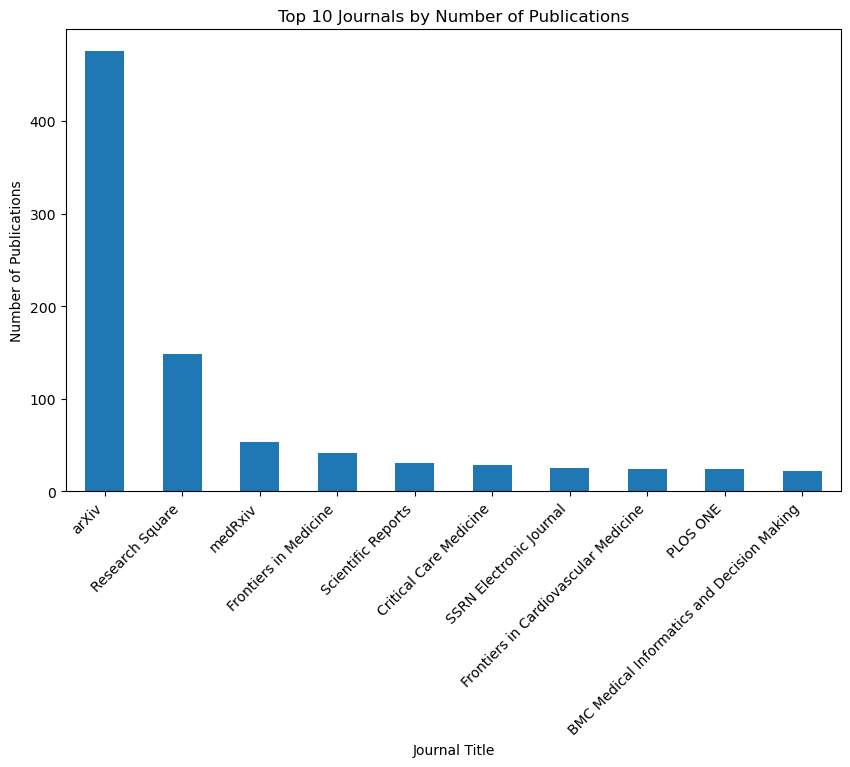

In [351]:
# Assuming the MIMIC_pubs dataframe is named 'MIMIC_pubs'
# Group the dataframe by 'journal.title' and count the number of publications for each journal
journal_counts = MIMIC_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)

print("MIMIC Top 10 journals by the number of publications:")
print(top_10_journals)

import pandas as pd
import matplotlib.pyplot as plt
# Group the dataframe by 'journal.title' and count the number of publications for each journal
journal_counts = MIMIC_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)
print("Top3 count:",475+148+53,"Top 3 journal %",(475+148+53)/len(MIMIC_pubs), "MIMIC totle pubs", len(MIMIC_pubs))
# Create a bar plot of the top 10 journals
fig, ax = plt.subplots(figsize=(10, 6))
top_10_journals.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of Publications')
ax.set_xlabel('Journal Title')
ax.set_title('Top 10 Journals by Number of Publications')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [26]:
# Load data 
Control_pubs =  pd.read_csv("./MIMIC_Files/control_group_pubs.csv")
MIMIC_pubs = pd.read_csv("./MIMIC_Files/mimic_pubs.csv")

MIMIC_author = pd.read_csv("./MIMIC_Files/mimic_auths.csv")
Control_author = pd.read_csv("./MIMIC_Files/control_group_auths.csv")

MIMIC_affli = pd.read_csv("./MIMIC_Files/mimic_affils.csv")
Control_affli = pd.read_csv("./MIMIC_Files/control_group_affils.csv")

Control_pubs.columns

Index(['Unnamed: 0', 'id', 'title', 'abstract', 'authors', 'authors_count',
       'category_for', 'category_rcdc', 'category_sdg', 'category_uoa',
       'concepts_scores', 'doi', 'funder_countries', 'funders', 'issue',
       'mesh_terms', 'open_access', 'pages', 'pmid', 'publisher',
       'research_org_cities', 'research_org_countries',
       'research_org_country_names', 'research_org_names', 'research_orgs',
       'researchers', 'supporting_grant_ids', 'times_cited', 'type', 'volume',
       'year', 'journal.id', 'journal.title', 'category_hra',
       'category_hrcs_hc', 'category_hrcs_rac', 'research_org_state_names',
       'category_bra', 'research_org_state_codes', 'editors',
       'category_icrp_cso', 'category_icrp_ct', 'field_citation_ratio',
       'relative_citation_ratio', 'author_count_categories', 'first_names',
       'genders', 'num_female', 'num_male', 'num_na', 'pct_female_real',
       'female_first', 'female_last', 'pct_female_pessimistic',
       'pct_femal

Control Top 10 journals by the number of publications:
journal.title
EMBC                                            99
PLOS ONE                                        71
Critical Care Medicine                          68
Scientific Reports                              68
Journal of Clinical Monitoring and Computing    44
Computers in Biology and Medicine               35
Computer Methods and Programs in Biomedicine    32
Sensors                                         32
Critical Care                                   32
BMC Medical Informatics and Decision Making     30
dtype: int64
Top3 count: 238 Top 3 journal % 0.08173076923076923 MIMIC totle pubs 2912
journal.title
EMBC                                            99
PLOS ONE                                        71
Critical Care Medicine                          68
Scientific Reports                              68
Journal of Clinical Monitoring and Computing    44
Computers in Biology and Medicine               35
Computer Metho

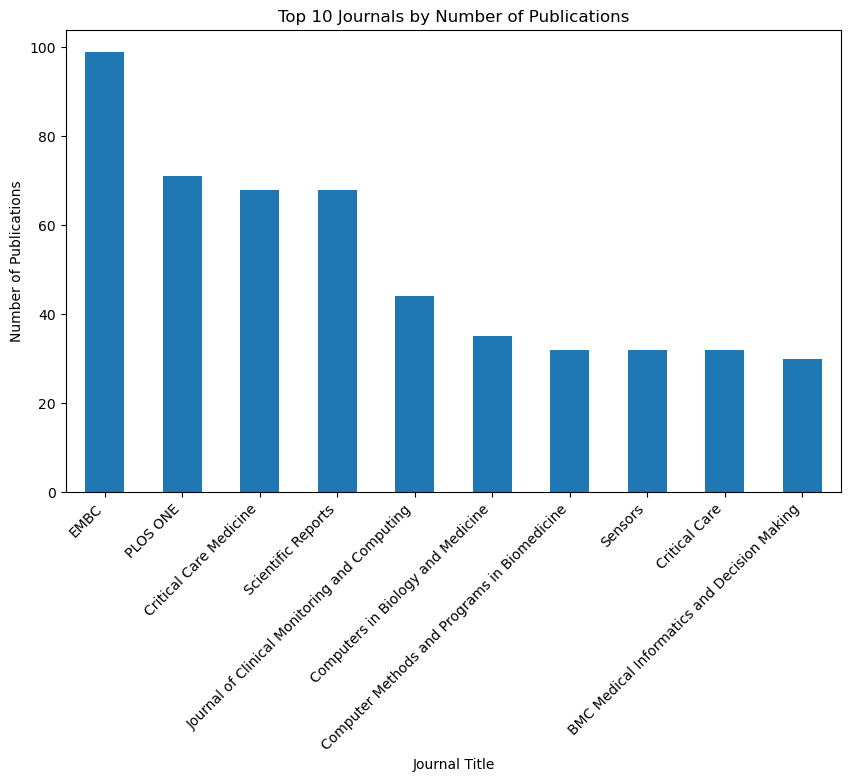

In [28]:

# Group the dataframe by 'journal.title' and count the number of publications for each journal
Control_pubs['journal.title'] = Control_pubs['journal.title'].replace("Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC)","EMBC")
journal_counts = Control_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)

print("Control Top 10 journals by the number of publications:")
print(top_10_journals)
print("Top3 count:",99+71+68,"Top 3 journal %",(99+71+68)/len(Control_pubs), "MIMIC totle pubs", len(Control_pubs))

# Group the dataframe by 'journal.title' and count the number of publications for each journal

journal_counts = Control_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)

# top_10_journals =top_10_journals.title.replace("Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC)","EMBC")
print(top_10_journals)
# Create a bar plot of the top 10 journals
fig, ax = plt.subplots(figsize=(10, 6))
top_10_journals.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of Publications')
ax.set_xlabel('Journal Title')
ax.set_title('Top 10 Journals by Number of Publications')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [92]:

# Create a boolean column indicating if a paper has a missing affiliation for any author
MIMIC_affli['missing_affiliation'] = MIMIC_affli['aff_country'].isna() | MIMIC_affli['aff_country_code'].isna()

# Group by publication and aggregate the 'missing_affiliation' column with 'any' function
grouped_affiliations = MIMIC_affli.groupby('pub_id')['missing_affiliation'].agg('any').reset_index(name='any_missing_affiliation')

# Filter the papers with non-missing affiliations
MIMIC_papers_with_non_missing_affiliations = grouped_affiliations[grouped_affiliations['any_missing_affiliation'] == False]
MIMIC_non_missing_pubid =MIMIC_papers_with_non_missing_affiliations.pub_id 
# print(MIMIC_papers_with_non_missing_affiliations.pub_id)
# Calculate the percentage of papers with at least one author with a missing affiliation
num_papers = len(grouped_affiliations)
num_papers_with_missing_affiliation = grouped_affiliations['any_missing_affiliation'].sum()
percentage_papers_with_missing_affiliation = (num_papers_with_missing_affiliation / num_papers) * 100
print(f"MIMIC paper count {num_papers}")
print(f"MIMIC Number of papers with non-missing country information: {len(MIMIC_papers_with_non_missing_affiliations)}")
print(f"MIMIC Number of paper with missing country information {num_papers_with_missing_affiliation}")
print(f"{percentage_papers_with_missing_affiliation:.2f}% of papers had at least one author with a missing country information.")


MIMIC paper count 1672
MIMIC Number of papers with non-missing country information: 1487
MIMIC Number of paper with missing country information 185
11.06% of papers had at least one author with a missing country information.


In [ ]:
print((185+183), (185+183)/(1672+2877))
print(185, 185/1672)
print(183, 183/2877)

368 0.08089690041767421
185 0.11064593301435406
183 0.06360792492179354


In [89]:

# Create a boolean column indicating if a paper has a missing affiliation for any author
Control_affli['missing_affiliation'] = Control_affli['aff_country'].isna() | Control_affli['aff_country_code'].isna()

# Group by publication and aggregate the 'missing_affiliation' column with 'any' function
grouped_affiliations = Control_affli.groupby('pub_id')['missing_affiliation'].agg('any').reset_index(name='any_missing_affiliation')

# Filter the papers with non-missing affiliations
Control_papers_with_non_missing_affiliations = grouped_affiliations[grouped_affiliations['any_missing_affiliation'] == False]
Control_non_missing_pubid =Control_papers_with_non_missing_affiliations.pub_id 
# print(Control_papers_with_non_missing_affiliations.pub_id)
# Calculate the percentage of papers with at least one author with a missing affiliation
num_papers = len(grouped_affiliations)
num_papers_with_missing_affiliation = grouped_affiliations['any_missing_affiliation'].sum()
percentage_papers_with_missing_affiliation = (num_papers_with_missing_affiliation / num_papers) * 100
print(f"Control total papers {num_papers}")
print(f"Control number of papers with missing country {num_papers_with_missing_affiliation}")
print(f"Control Number of papers with non-missing country information: {len(Control_papers_with_non_missing_affiliations)}")
print(f"{percentage_papers_with_missing_affiliation:.2f}% of papers had at least one author with a missing country information.")


Control total papers 2877
Control number of papers with missing country 183
Control Number of papers with non-missing country information: 2694
6.36% of papers had at least one author with a missing country information.


In [90]:
MIMIC_affli.pub_id.value_counts()

MIMIC_author_counts = MIMIC_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with only one author
MIMIC_single_author_papers = MIMIC_author_counts[MIMIC_author_counts == 1].count()

print(f"MIMIC Number of papers with only one author: {MIMIC_single_author_papers}")

MIMIC Number of papers with only one author: 104


In [86]:
Control_affli.pub_id.value_counts()


# Assuming 'df' is your DataFrame with 'pub_id' and 'researcher_id' columns
# Group by 'pub_id' and count the number of unique authors for each publication
Control_author_counts = Control_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with only one author
Control_single_author_papers = Control_author_counts[Control_author_counts == 1].count()

print(f"Control Number of papers with only one author: {Control_single_author_papers}")

Control Number of papers with only one author: 178


In [ ]:
Control_affli.income_class.value_counts()

income_class
High income            19798
Upper middle income     4278
Lower middle income      742
Low income                14
Name: count, dtype: int64

### Any LMIC count

In [93]:
#### Pleae note  here I've changed the MIMIC_affli, and Control_affli with non missing affiliations pubids 
MIMIC_affiliation_original = MIMIC_affli
Control_affilation_original = Control_affli
MIMIC_affli = MIMIC_affli[MIMIC_affli.pub_id.isin(MIMIC_non_missing_pubid)]
Control_affli = Control_affli[Control_affli.pub_id.isin(Control_non_missing_pubid)]

In [98]:
# # Please only run this cell once 
# # Convert 'Yes' and 'No' in 'LMIC' column to 1 and 0
# MIMIC_affli['LMIC'] = MIMIC_affli['LMIC'].map({'Yes': 1, 'No': 0}) # Note this line should be only use one time
# # Convert 'Yes' and 'No' in 'LMIC' column to 1 and 0
# Control_affli['LMIC'] = Control_affli['LMIC'].map({'Yes': 1, 'No': 0})


/var/folders/v0/r16j2f9545n7rrq_rvqlxn180000gn/T/ipykernel_36091/1288947939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIMIC_affli['LMIC'] = MIMIC_affli['LMIC'].map({'Yes': 1, 'No': 0}) # Note this line should be only use one time
/var/folders/v0/r16j2f9545n7rrq_rvqlxn180000gn/T/ipykernel_36091/1288947939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Control_affli['LMIC'] = Control_affli['LMIC'].map({'Yes': 1, 'No': 0})


In [99]:

print("LMIC count for all papers ")
print("Control")
Control_lmic_count = Control_affli[Control_affli['LMIC'] == 1].groupby('pub_id').agg({'LMIC': 'count'}).reset_index()
print("LMIC>0",len(Control_lmic_count[Control_lmic_count.LMIC>0]))
print("MIMIC")
MIMIC_lmic_count = MIMIC_affli[MIMIC_affli['LMIC'] == 1].groupby('pub_id').agg({'LMIC': 'count'}).reset_index()
print("LMIC>0",len(MIMIC_lmic_count[MIMIC_lmic_count.LMIC>0]))
print("all papers",Control_affli.pub_id.nunique()+MIMIC_affli.pub_id.nunique())
print((168+150)/4181)

LMIC count for all papers 
Control
LMIC>0 168
MIMIC
LMIC>0 150
all papers 4181
0.07605835924419996


In [100]:
IncomeByPub = MIMIC_affli[['pub_id','income_class_num']].groupby(['pub_id']).agg([ 'count','mean']).reset_index()

In [101]:
print("for all papers ")
# Determine unique 'pub_id's with at least one LMIC author
lmic_pubs = MIMIC_affli[MIMIC_affli['LMIC'] == 1]['pub_id'].nunique()

# Calculate the total number of unique 'pub_id's
total_pubs = MIMIC_affli['pub_id'].nunique()

# Calculate the percentage
percentage_lmic = (lmic_pubs / total_pubs) * 100

print(f"Overall,{lmic_pubs}/{total_pubs}( {percentage_lmic:.2f}% )of MIMIC articles in the considered set had at least one LMIC author.")

# Repeat the same for Control dataset

lmic_pubs_control = Control_affli[Control_affli['LMIC'] == 1]['pub_id'].nunique()
total_pubs_control = Control_affli['pub_id'].nunique()
percentage_lmic_control = (lmic_pubs_control / total_pubs_control) * 100

print(f"Overall,{lmic_pubs_control}/{total_pubs_control}( {percentage_lmic_control:.2f}% ) of Control articles in the considered set had at least one LMIC author.")

# Concatenate the two DataFrames
combined_affli = pd.concat([MIMIC_affli, Control_affli])

# Determine unique 'pub_id's with at least one LMIC author
lmic_pubs_combined = combined_affli[combined_affli['LMIC'] == 1]['pub_id'].nunique()

# Calculate the total number of unique 'pub_id's
total_pubs_combined = combined_affli['pub_id'].nunique()

# Calculate the percentage
percentage_lmic_combined = (lmic_pubs_combined / total_pubs_combined) * 100

print(f"Overall, {lmic_pubs_combined}/{total_pubs_combined}( {percentage_lmic_combined:.2f}% ) of articles in the combined set had at least one LMIC author.")


for all papers 
Overall,150/1487( 10.09% )of MIMIC articles in the considered set had at least one LMIC author.
Overall,168/2694( 6.24% ) of Control articles in the considered set had at least one LMIC author.
Overall, 318/4181( 7.61% ) of articles in the combined set had at least one LMIC author.


In [102]:
from scipy.stats import norm

# Given data
p1 = 10.09 / 100  # MIMIC/eICU proportion (8.32%)
p2 = 6.24 / 100  # Control proportion (5.51%)
n1 = 1487       # MIMIC/eICU sample size
n2 = 2694       # Control sample size

# Calculating the pooled proportion
x1 = p1 * n1  # Number of successes in MIMIC/eICU
x2 = p2 * n2  # Number of successes in Control
pooled_p = (x1 + x2) / (n1 + n2)

# Calculating the Z-score
z_score = (p1 - p2) / ((pooled_p * (1 - pooled_p) * (1/n1 + 1/n2)) ** 0.5)

# Calculating the p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test

print("Z-score:", z_score)
print("p-value:", p_value)

Z-score: 4.494579099552951
p-value: 6.970768869463129e-06


In [362]:
len(MIMIC_affli.groupby('pub_id').filter(lambda x: len(x) >= 2))

12309

In [364]:
print("MIMIC")
MIMIC_papers_with_two_or_more_authors = MIMIC_affli.groupby('pub_id').filter(lambda x: len(x) >= 2)
print("papers with two or more authors,author list",len(MIMIC_papers_with_two_or_more_authors))
print("papers count ", len(MIMIC_affli.groupby('pub_id')))
print("papers with two or more authors, paper count ", len(MIMIC_papers_with_two_or_more_authors.groupby('pub_id')))

# Group papers by publication id and count the number of LMIC authors per paper
MIMIC_lmic_counts = MIMIC_papers_with_two_or_more_authors[MIMIC_papers_with_two_or_more_authors['LMIC'] == 1].groupby('pub_id')['LMIC'].count()
print("papers with lmic authors count", len(MIMIC_lmic_counts))

# Calculate the percentage of papers with multiple LMIC authors
MIMIC_papers_with_multiple_lmic_authors = MIMIC_lmic_counts[MIMIC_lmic_counts >= 2].index
MIMIC_percentage_multiple_lmic_authors = (len(MIMIC_papers_with_multiple_lmic_authors) / len(MIMIC_papers_with_two_or_more_authors['pub_id'].unique())) * 100

# Determine papers where the first author is affiliated with a LMIC country
MIMIC_first_authors = MIMIC_papers_with_two_or_more_authors.groupby('pub_id').first()
MIMIC_last_authors = MIMIC_papers_with_two_or_more_authors.groupby("pub_id").last()

MIMIC_papers_with_first_author_lmic = MIMIC_first_authors[MIMIC_first_authors['LMIC'] == 1].index
MIMIC_papers_with_last_author_lmic = MIMIC_last_authors[MIMIC_last_authors['LMIC'] == 1].index
print("first_authors",len(MIMIC_papers_with_first_author_lmic))
print("last_authors:",len(MIMIC_papers_with_last_author_lmic) )
# Calculate the percentage of papers where the first author is affiliated with a LMIC country
MIMIC_percentage_first_author_lmic = (len(MIMIC_papers_with_first_author_lmic) / len(MIMIC_papers_with_two_or_more_authors['pub_id'].unique())) * 100
MIMIC_percentage_last_author_lmic = (len(MIMIC_papers_with_last_author_lmic) / len(MIMIC_papers_with_two_or_more_authors['pub_id'].unique())) * 100

print(f"Among articles with two authors or more,{len(MIMIC_papers_with_multiple_lmic_authors )} ( {MIMIC_percentage_multiple_lmic_authors:.2f}%) had multiple LMIC authors.")
print(f"Additionally, the first author was affiliated with a LMIC country in {len(MIMIC_papers_with_first_author_lmic)} ({MIMIC_percentage_first_author_lmic:.2f})% of papers with two or more authors.")
print(f"the last author was affiliated with a LMIC country in {len(MIMIC_papers_with_last_author_lmic)} ({MIMIC_percentage_last_author_lmic:.2f})% of papers with two or more authors.")

MIMIC
papers with two or more authors,author list 12309
papers count  1487
papers with two or more authors, paper count  1464
papers with lmic authors count 148
first_authors 115
last_authors: 114
Among articles with two authors or more,133 ( 9.08%) had multiple LMIC authors.
Additionally, the first author was affiliated with a LMIC country in 115 (7.86)% of papers with two or more authors.
the last author was affiliated with a LMIC country in 114 (7.79)% of papers with two or more authors.


In [365]:
print("Control")
Control_papers_with_two_or_more_authors = Control_affli.groupby('pub_id').filter(lambda x: len(x) >= 2)
print("papers with two or more authors,author list",len(Control_papers_with_two_or_more_authors))
print("papers count ", len(Control_affli.groupby('pub_id')))
print("papers with two or more authors, paper count ", len(Control_papers_with_two_or_more_authors.groupby('pub_id')))

# Group papers by publication id and count the number of LMIC authors per paper
Control_lmic_counts = Control_papers_with_two_or_more_authors[Control_papers_with_two_or_more_authors['LMIC'] == 1].groupby('pub_id')['LMIC'].count()
print("papers with lmic authors count", len(Control_lmic_counts))

# Calculate the percentage of papers with multiple LMIC authors
Control_papers_with_multiple_lmic_authors = Control_lmic_counts[Control_lmic_counts >= 2].index
Control_percentage_multiple_lmic_authors = (len(Control_papers_with_multiple_lmic_authors) / len(Control_papers_with_two_or_more_authors['pub_id'].unique())) * 100

# Determine papers where the first author is affiliated with a LMIC country
Control_first_authors = Control_papers_with_two_or_more_authors.groupby('pub_id').first()
Control_last_authors = Control_papers_with_two_or_more_authors.groupby("pub_id").last()

Control_papers_with_first_author_lmic = Control_first_authors[Control_first_authors['LMIC'] == 1].index
Control_papers_with_last_author_lmic = Control_last_authors[Control_last_authors['LMIC'] == 1].index
print("first_authors",len(Control_papers_with_first_author_lmic))
print("last_authors:",len(Control_papers_with_last_author_lmic) )
# Calculate the percentage of papers where the first author is affiliated with a LMIC country
Control_percentage_first_author_lmic = (len(Control_papers_with_first_author_lmic) / len(Control_papers_with_two_or_more_authors['pub_id'].unique())) * 100
Control_percentage_last_author_lmic = (len(Control_papers_with_last_author_lmic) / len(Control_papers_with_two_or_more_authors['pub_id'].unique())) * 100

print(f"Among articles with two authors or more,{len(Control_papers_with_multiple_lmic_authors )} ( {Control_percentage_multiple_lmic_authors:.2f}%) had multiple LMIC authors.")
print(f"Additionally, the first author was affiliated with a LMIC country in {len(Control_papers_with_first_author_lmic)} ({Control_percentage_first_author_lmic:.2f})% of papers with two or more authors.")
print(f"the last author was affiliated with a LMIC country in {len(Control_papers_with_last_author_lmic)} ({Control_percentage_last_author_lmic:.2f})% of papers with two or more authors.")

Control
papers with two or more authors,author list 23127
papers count  2694
papers with two or more authors, paper count  2564
papers with lmic authors count 161
first_authors 123
last_authors: 116
Among articles with two authors or more,141 ( 5.50%) had multiple LMIC authors.
Additionally, the first author was affiliated with a LMIC country in 123 (4.80)% of papers with two or more authors.
the last author was affiliated with a LMIC country in 116 (4.52)% of papers with two or more authors.


In [370]:

# Given data
p1 = 7.86 / 100  # MIMIC/eICU proportion (8.32%)
p2 = 4.80 / 100  # Control proportion (5.51%)
n1 = 1464       # MIMIC/eICU sample size
n2 = 2564       # Control sample size

# Calculating the pooled proportion
x1 = p1 * n1  # Number of successes in MIMIC/eICU
x2 = p2 * n2  # Number of successes in Control
pooled_p = (x1 + x2) / (n1 + n2)

# Calculating the Z-score
z_score = (p1 - p2) / ((pooled_p * (1 - pooled_p) * (1/n1 + 1/n2)) ** 0.5)

# Calculating the p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test

print("Z-score:", z_score)
print("p-value:", p_value)

Z-score: 3.960644813615911
p-value: 7.474764598436323e-05


In [372]:

# Given data
p1 = 7.79 / 100  # MIMIC/eICU proportion (8.32%)
p2 = 4.52 / 100  # Control proportion (5.51%)
n1 = 1464       # MIMIC/eICU sample size
n2 = 2564       # Control sample size

# Calculating the pooled proportion
x1 = p1 * n1  # Number of successes in MIMIC/eICU
x2 = p2 * n2  # Number of successes in Control
pooled_p = (x1 + x2) / (n1 + n2)

# Calculating the Z-score
z_score = (p1 - p2) / ((pooled_p * (1 - pooled_p) * (1/n1 + 1/n2)) ** 0.5)

# Calculating the p-value
p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test

print("Z-score:", z_score)
print("p-value:", p_value)

Z-score: 4.302642649100796
p-value: 1.687729399124649e-05


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Sample sizes and proportions
n1 = 1672  # MIMIC/eICU sample size
n2 = 2877  # Control sample size
p1 = 8.32 / 100  # MIMIC/eICU proportion (8.32%)
p2 = 5.51 / 100  # Control proportion (5.51%)

# Create arrays representing successes and failures
data1 = np.array([1] * int(p1 * n1) + [0] * (n1 - int(p1 * n1)))  # MIMIC/eICU data
data2 = np.array([1] * int(p2 * n2) + [0] * (n2 - int(p2 * n2)))  # Control data

# Perform the t-test
t_stat, p_value = ttest_ind(data1, data2)

print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: 3.7189926093958356
p-value: 0.00020242966788798516


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Sample sizes and proportions
n1 = 1672  # MIMIC/eICU sample size
n2 = 2877  # Control sample size
p1 = 7.14 / 100  # MIMIC/eICU proportion (8.32%)
p2 = 4.59 / 100  # Control proportion (5.51%)

# Create arrays representing successes and failures
data1 = np.array([1] * int(p1 * n1) + [0] * (n1 - int(p1 * n1)))  # MIMIC/eICU data
data2 = np.array([1] * int(p2 * n2) + [0] * (n2 - int(p2 * n2)))  # Control data

# Perform the t-test
t_stat, p_value = ttest_ind(data1, data2)

print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: 3.6063577533772753
p-value: 0.0003138582477199251


## Statistics for LMIC analyses

In [374]:
MIMIC_paper_count = len(MIMIC_affli.groupby('pub_id'))
MIMIC_first_authors = MIMIC_affli.groupby('pub_id').first().reset_index()
MIMIC_last_authors = MIMIC_affli.groupby('pub_id').last().reset_index()
MIMIC_first_author_lmic_count = MIMIC_first_authors[MIMIC_first_authors['LMIC'] == 1].shape[0]
MIMIC_last_author_lmic_count = MIMIC_last_authors[MIMIC_last_authors['LMIC'] == 1].shape[0]

MIMIC_lmic_authors = MIMIC_affli[MIMIC_affli['LMIC'] == 1]

# Drop duplicate 'pub_id' values to count unique publications
MIMIC_unique_lmic_papers = MIMIC_lmic_authors.drop_duplicates(subset='pub_id')

# Count the number of unique publications with at least one LMIC author
MIMIC_num_lmic_papers = len(MIMIC_unique_lmic_papers)

print(f"MIMIC Number of publications with any author from LMIC: {MIMIC_num_lmic_papers}({MIMIC_num_lmic_papers/MIMIC_paper_count*100}%)")
print(f"MIMIC Number of first authors from LMIC: {MIMIC_first_author_lmic_count} ({MIMIC_first_author_lmic_count/MIMIC_paper_count*100}%)")
print(f"MIMIC Number of last authors from LMIC: {MIMIC_last_author_lmic_count} ({MIMIC_last_author_lmic_count/MIMIC_paper_count*100}%)")
print(f"MIMIC Number of papers with only one author: {MIMIC_single_author_papers}({MIMIC_single_author_papers/MIMIC_paper_count*100}%)")

MIMIC Number of publications with any author from LMIC: 150(10.087424344317418%)
MIMIC Number of first authors from LMIC: 117 (7.868190988567586%)
MIMIC Number of last authors from LMIC: 116 (7.800941492938803%)
MIMIC Number of papers with only one author: 104(6.99394754539341%)


In [375]:
Control_paper_count = len(Control_affli.groupby('pub_id'))
Control_first_authors = Control_affli.groupby('pub_id').first().reset_index()
Control_last_authors = Control_affli.groupby('pub_id').last().reset_index()
Control_first_author_lmic_count = Control_first_authors[Control_first_authors['LMIC'] == 1].shape[0]
Control_last_author_lmic_count = Control_last_authors[Control_last_authors['LMIC'] == 1].shape[0]

Control_lmic_authors = Control_affli[Control_affli['LMIC'] == 1]

# Drop duplicate 'pub_id' values to count unique publications
Control_unique_lmic_papers = Control_lmic_authors.drop_duplicates(subset='pub_id')

# Count the number of unique publications with at least one LMIC author
Control_num_lmic_papers = len(Control_unique_lmic_papers)

print(f"Control Number of publications with any author from LMIC: {Control_num_lmic_papers}({Control_num_lmic_papers/Control_paper_count*100}%)")
print(f"Control Number of first authors from LMIC: {Control_first_author_lmic_count} ({Control_first_author_lmic_count/Control_paper_count*100}%)")
print(f"Control Number of last authors from LMIC: {Control_last_author_lmic_count} ({Control_last_author_lmic_count/Control_paper_count*100}%)")
print(f"Control Number of papers with only one author: {Control_single_author_papers}({Control_single_author_papers/Control_paper_count*100}%)")

Control Number of publications with any author from LMIC: 168(6.23608017817372%)
Control Number of first authors from LMIC: 130 (4.825538233110616%)
Control Number of last authors from LMIC: 123 (4.565701559020044%)
Control Number of papers with only one author: 178(6.607275426874535%)


In [103]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
# Number of successes (LMIC authors) in each group
counts = np.array([156, 182])

# Total number of observations in each group
nobs = np.array([1672, 2877])

# Perform the Z-test with the alternative hypothesis stating that the proportion in the MIMIC/eICU group is greater than the control group
z_stat, p_value = proportions_ztest(counts, nobs, alternative='larger')

print(f"Z-stat: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-stat: 3.7249
P-value: 0.0001


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Number of successes (LMIC authors) in each group
counts = np.array([156, 182])

# Total number of observations in each group
nobs = np.array([1672, 2877])

# Creating arrays that represent successes and failures for each group
group1 = np.array([1]*counts[0] + [0]*(nobs[0] - counts[0]))
group2 = np.array([1]*counts[1] + [0]*(nobs[1] - counts[1]))

# Perform the two-sample t-test for independent samples
t_stat, p_value = ttest_ind(group1, group2, equal_var=False, alternative='greater')

print(f"T-stat: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-stat: 3.5594
P-value: 0.0002


In [104]:
# Concatenate the two DataFrames
combined_affli = pd.concat([MIMIC_affli, Control_affli])

# Determine unique 'pub_id's with at least one LMIC author
lmic_pubs_combined = combined_affli[combined_affli['LMIC'] == 1]['pub_id'].nunique()

# Calculate the total number of unique 'pub_id's
total_pubs_combined = combined_affli['pub_id'].nunique()

# Calculate the percentage
percentage_lmic_combined = (lmic_pubs_combined / total_pubs_combined) * 100

print(f"Overall, {percentage_lmic_combined:.2f}% of articles in the combined set had at least one LMIC author.")
# Gender intersection

# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
combined_affli_filtered = combined_affli.dropna(subset=['gender', 'LMIC'])

# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = combined_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()

# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"combined Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")

Overall, 7.61% of articles in the combined set had at least one LMIC author.
combined Among the 3884 papers with non-missing gender and LMIC status information, 5.12% had at least one woman and one LMIC-based researcher among the authors.


In [105]:
# Combine MIMIC and Control datasets
combined_affli = pd.concat([MIMIC_affli, Control_affli])

# Group by 'pub_id' and count the total number of authors for each publication
total_author_counts = combined_affli.groupby('pub_id').size()

# Filter the results to get the number of papers with two or more authors
two_or_more_authors_papers = total_author_counts[total_author_counts >= 2].index

# Get a new DataFrame with only papers with two or more authors
two_or_more_authors_df = combined_affli[combined_affli['pub_id'].isin(two_or_more_authors_papers)]

# Get the first and last author for each publication
first_authors = two_or_more_authors_df.groupby('pub_id').first()
last_authors = two_or_more_authors_df.groupby('pub_id').last()

# Filter the DataFrame to get rows with LMIC first authors and last authors
lmic_first_authors = first_authors[first_authors['LMIC'] == 1]
lmic_last_authors = last_authors[last_authors['LMIC'] == 1]

# Count the number of papers with the first author and the last author from LMIC
num_lmic_first_authors = lmic_first_authors['LMIC'].count()
num_lmic_last_authors = lmic_last_authors['LMIC'].count()

# Calculate the percentage of papers with the first author and the last author from LMIC among those with two or more authors
percentage_lmic_first_authors = (num_lmic_first_authors / total_author_counts.count()) * 100
percentage_lmic_last_authors = (num_lmic_last_authors / total_author_counts.count()) * 100

print(f"Combined Percentage of papers with two or more authors having the first author from LMIC: {percentage_lmic_first_authors:.2f}%")
print(f"Combined Percentage of papers with two or more authors having the last author from LMIC: {percentage_lmic_last_authors:.2f}%")


Combined Percentage of papers with two or more authors having the first author from LMIC: 5.69%
Combined Percentage of papers with two or more authors having the last author from LMIC: 5.50%


In [ ]:
MIMIC_affli['gender'].value_counts()

gender
male      8962
female    3362
Name: count, dtype: int64

### LMIC & Gender intersection 

#### based on none-missing affiliation 

In [106]:


# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information

MIMIC_affli_filtered = MIMIC_affli.dropna(subset=['gender', 'LMIC'])
MIMIC_affli_filtered =MIMIC_affli_filtered[MIMIC_affli_filtered.pub_id.isin(df_affils_compare_processed.pub_id)] 
# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = MIMIC_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()

# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"MIMIC Among the {total_papers} papers with non-missing gender and LMIC status information, {papers_count} ({percentage_woman_and_lmic_authors:.2f})% had at least one female LMIC-based researcher among the authors.")

# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
Control_affli_filtered = Control_affli.dropna(subset=['gender', 'LMIC'])
Control_affli_filtered = Control_affli_filtered[Control_affli_filtered.pub_id.isin(df_affils_control_processed.pub_id)]
# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = Control_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()

# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"Control Among the {total_papers} papers with non-missing gender and LMIC status information,{papers_count }( {percentage_woman_and_lmic_authors:.2f} %)  had at least one female LMIC-based researcher among the authors.")

MIMIC Among the 945 papers with non-missing gender and LMIC status information, 59 (6.24)% had at least one female LMIC-based researcher among the authors.
Control Among the 1698 papers with non-missing gender and LMIC status information,64( 3.77 %)  had at least one female LMIC-based researcher among the authors.


##### based on non-missing gender& affiliation 

In [384]:
df_affils_compare_processed.pub_id.count()


7377

In [107]:


# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
MIMIC_affli_filter_missing_gender = MIMIC_affli[MIMIC_affli.pub_id.isin(df_affils_compare_processed.pub_id)]
MIMIC_affli_filtered = MIMIC_affli_filter_missing_gender.dropna(subset=['gender', 'LMIC'])

# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = MIMIC_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()
print("MIMIC papers with women and lmic, count", papers_count)
# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"MIMIC Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")
# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
Control_affli_filter_missing_gender = Control_affli[Control_affli.pub_id.isin(df_affils_control_processed.pub_id)]
Control_affli_filtered = Control_affli_filter_missing_gender.dropna(subset=['gender', 'LMIC'])

# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = Control_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()
print("Control papers with women and lmic, count", papers_count)
# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"Control Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")

MIMIC papers with women and lmic, count 59
MIMIC Among the 945 papers with non-missing gender and LMIC status information, 6.24% had at least one woman and one LMIC-based researcher among the authors.
Control papers with women and lmic, count 64
Control Among the 1698 papers with non-missing gender and LMIC status information, 3.77% had at least one woman and one LMIC-based researcher among the authors.


In [432]:
1698+945

2643

In [108]:

# Proportions provided
mimic_proportion = 6.24 / 100
control_proportion = 3.77 / 100

# Total number of papers with non-missing gender and LMIC status information
mimic_total_papers = 945
control_total_papers = 1698

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
mimic_papers_count = int(mimic_total_papers * mimic_proportion)
control_papers_count = int(control_total_papers * control_proportion)

# Perform the two-proportion Z-test
z_stat, p_value = proportions_ztest([mimic_papers_count, control_papers_count],
                                    [mimic_total_papers, control_total_papers],
                                    alternative='larger')

print(f"one-sided Two-proportion Z-test:{z_stat} p-value = {p_value:.4f}")

one-sided Two-proportion Z-test:2.781165322109097 p-value = 0.0027


In [434]:
MIMIC_affli[(MIMIC_affli['gender']=='female')&( MIMIC_affli['LMIC']==1)].groupby('pub_id').agg({'researcher_id':'count'}).reset_index()

,pub_id,researcher_id
0,pub.1019691504,3
1,pub.1074224378,2
2,pub.1101317185,2
3,pub.1101564693,2
4,pub.1107839160,2
...,...,...
81,pub.1154093154,1
82,pub.1154120926,1
83,pub.1154361520,4
84,pub.1154887220,1


In [390]:
# Assuming MIMIC_affli is the DataFrame you're working with
MIMIC_none_missing_affli_gender_count = len(MIMIC_affli_filter_missing_gender.pub_id.unique())
Control_none_missing_affli_gender_count = len(Control_affli_filter_missing_gender.pub_id.unique())
                            
MIMIC_num_papers, MIMIC_percent = get_papers_with_woman_and_lmic(MIMIC_affli_filter_missing_gender,MIMIC_none_missing_affli_gender_count )
Control_num_papers, Control_percent = get_papers_with_woman_and_lmic(Control_affli_filter_missing_gender,Control_none_missing_affli_gender_count )
print(f"In the treatment group comprising {MIMIC_none_missing_affli_gender_count} papers, {MIMIC_num_papers} ({MIMIC_percent:.2f}%) featured at least one woman and at least one LMIC-based researcher among the authors.")
print(f"In the control group comprising {Control_none_missing_affli_gender_count} papers, {Control_num_papers} ({Control_percent:.2f}%) featured at least one woman and at least one LMIC-based researcher among the authors.")


In the treatment group comprising 945 papers, 49 (5.19%) featured at least one woman and at least one LMIC-based researcher among the authors.
In the control group comprising 1698 papers, 49 (2.89%) featured at least one woman and at least one LMIC-based researcher among the authors.


In [109]:
# Calculate the difference between the two groups
percentage_difference = (mimic_proportion - control_proportion) * 100

print(f"The difference between the two groups is {percentage_difference:.2f} percentage points.")


The difference between the two groups is 2.47 percentage points.


### Sensitivity Analyses

In [437]:
from statsmodels.stats.proportion import proportions_ztest
def sensitivity_analysis(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts, num_scenarios=10):
    # Calculate the proportion of LMIC authors in the known data for each group
    treatment_proportion = treatment_counts[0] / sum(treatment_counts)
    control_proportion = control_counts[0] / sum(control_counts)
    print("total treatment ",total_treatment_papers, "total control", total_control_papers )
 
    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers
    missing_papers = missing_treatment_papers + missing_control_papers

    p_values = []

    for i in range(num_scenarios + 1):
        # Vary the proportion of LMIC authors in the missing data
        treatment_missing = int(missing_papers * treatment_proportion * i / num_scenarios)
        control_missing = int(missing_papers * control_proportion * i / num_scenarios)

        # Calculate the adjusted counts of LMIC authors for each group
        adjusted_treatment_counts = treatment_counts[0] + treatment_missing
        adjusted_control_counts = control_counts[0] + control_missing

        # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the MIMIC/eICU group is greater than the control group
        z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                            [known_treatment_papers + missing_treatment_papers, known_control_papers + missing_control_papers],
                                            alternative='larger')

        p_values.append(p_value)

    return p_values


In [419]:
MIMIC_affli.pub_id.nunique()
# Control_pubs.id.nunique()

1487

In [420]:
total_treatment_papers = MIMIC_pubs.id.nunique()
total_control_papers = Control_pubs.id.nunique()
known_treatment_papers = MIMIC_affli.pub_id.nunique()
known_control_papers = Control_affli.pub_id.nunique()
n_MIMIC_lmic = len(MIMIC_lmic_count)
n_Control_lmic = len(Control_lmic_count)
treatment_counts = (n_MIMIC_lmic, known_treatment_papers - n_MIMIC_lmic)
control_counts = (n_Control_lmic, known_treatment_papers - n_Control_lmic)

p_values = sensitivity_analysis(total_treatment_papers, known_treatment_papers,
                                treatment_counts, control_counts)

for i, p_value in enumerate(p_values):
    print(f"Scenario {i}: p-value = {p_value:.4f}")


total treatment  2307 total control 2912
Scenario 0: p-value = 0.1359
Scenario 1: p-value = 0.1255
Scenario 2: p-value = 0.1261
Scenario 3: p-value = 0.1147
Scenario 4: p-value = 0.1061
Scenario 5: p-value = 0.0966
Scenario 6: p-value = 0.0970
Scenario 7: p-value = 0.0883
Scenario 8: p-value = 0.0818
Scenario 9: p-value = 0.0745
Scenario 10: p-value = 0.0747


In [423]:
#  Set data
# Replace these values with your data
total_treatment_papers = len(MIMIC_pubs.id.unique())
total_control_papers = len(Control_pubs.id.unique())
known_treatment_papers = MIMIC_affli.pub_id.nunique()
known_control_papers = Control_affli.pub_id.nunique()
first_treatment_counts = (num_MIMIC_lmic_first_authors, known_treatment_papers - num_MIMIC_lmic_first_authors)
first_control_counts = (num_Control_lmic_first_authors, known_control_papers - num_Control_lmic_first_authors)
last_treatment_counts = (num_MIMIC_lmic_last_authors, known_treatment_papers - num_MIMIC_lmic_last_authors)
last_control_counts = (num_Control_lmic_last_authors , known_control_papers - num_Control_lmic_last_authors)
n_MIMIC_lmic = len(MIMIC_lmic_count)
n_Control_lmic = len(Control_lmic_count)
treatment_counts = (n_MIMIC_lmic, known_treatment_papers - n_MIMIC_lmic)
control_counts = (n_Control_lmic, known_treatment_papers - n_Control_lmic)


In [424]:
# from statsmodels.stats.proportion import proportions_ztest

def sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers
    print("total treatment ",total_treatment_papers, "total control", total_control_papers )
    # Assume all the missing authors are from LMIC and add them to the known LMIC author counts
    adjusted_treatment_counts = treatment_counts[0] + missing_treatment_papers
    adjusted_control_counts = control_counts[0] + missing_control_papers
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the treatment group is greater than the control group
    z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                        [total_treatment_papers, total_control_papers],
                                        alternative='larger')

    return p_value, z_stat

overall_p_value,overall_z_stat = sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)

first_p_value , first_z_stat= sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value, last_z_stat = sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors from LMIC sensitivity analysis: overall_z{overall_z_stat:.3f}, p-value = {overall_p_value:.10f}")
print(f"first author All missing authors from LMIC sensitivity analysis: first_z:{first_z_stat:.3f}, p-value = {first_p_value:.10f}")
print(f"last author All missing authors from LMIC sensitivity analysis:last_z:{last_z_stat:.3f}, p-value = {last_p_value:.10f}")


total treatment  2307 total control 2912
adjusted treatment  count :  970
adjusted treatment proportion %:  42.04594711746857
adjusted control count % : 386
adjusted control proportion:  16.731686172518422
total treatment  2307 total control 2912
adjusted treatment  count :  927
adjusted treatment proportion %:  40.18205461638492
adjusted control count % : 332
adjusted control proportion:  14.390983961855222
total treatment  2307 total control 2912
adjusted treatment  count :  926
adjusted treatment proportion %:  40.13870827915041
adjusted control count % : 339
adjusted control proportion:  14.694408322496749
overall All missing authors from LMIC sensitivity analysis: overall_z23.554, p-value = 0.0000000000
first author All missing authors from LMIC sensitivity analysis: first_z:24.136, p-value = 0.0000000000
last author All missing authors from LMIC sensitivity analysis:last_z:23.859, p-value = 0.0000000000


In [425]:
import numpy as np
from scipy.stats import ttest_ind

def sensitivity_analysis_all_missing_lmic_ttest(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers
    print("total treatment ",total_treatment_papers, "total control", total_control_papers )
 

    # Assume all the missing authors are from LMIC and add them to the known LMIC author counts
    adjusted_treatment_counts = treatment_counts[0] + missing_treatment_papers
    adjusted_control_counts = control_counts[0] + missing_control_papers

    # Create arrays representing 'successes' and 'failures'
    treatment_data = np.array([1] * adjusted_treatment_counts + [0] * (total_treatment_papers - adjusted_treatment_counts))
    control_data = np.array([1] * adjusted_control_counts + [0] * (total_control_papers - adjusted_control_counts))

    # Perform the t-test
    t_stat, p_value = ttest_ind(treatment_data, control_data)

    return p_value, t_stat


overall_p_value,overall_t_stat = sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)

first_p_value , first_t_stat= sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value, last_t_stat = sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors from LMIC sensitivity analysis: t_stat{overall_t_stat:.3f},p-value = {overall_p_value:.3f}")
print(f"first author All missing authors from LMIC sensitivity analysis: p-value = {first_p_value:.3f}")
print(f"last author All missing authors from LMIC sensitivity analysis: p-value = {last_p_value:.3f}")
print("overall_4:", overall_t_stat)
print("first_4:", first_t_stat)
print("last_4:", last_t_stat)                                                             


total treatment  2307 total control 2912
adjusted treatment  count :  970
adjusted treatment proportion %:  42.04594711746857
adjusted control count % : 386
adjusted control proportion:  16.731686172518422
total treatment  2307 total control 2912
adjusted treatment  count :  927
adjusted treatment proportion %:  40.18205461638492
adjusted control count % : 332
adjusted control proportion:  14.390983961855222
total treatment  2307 total control 2912
adjusted treatment  count :  926
adjusted treatment proportion %:  40.13870827915041
adjusted control count % : 339
adjusted control proportion:  14.694408322496749
overall All missing authors from LMIC sensitivity analysis: t_stat23.554,p-value = 0.000
first author All missing authors from LMIC sensitivity analysis: p-value = 0.000
last author All missing authors from LMIC sensitivity analysis: p-value = 0.000
overall_4: 23.554257828886602
first_4: 24.135588028613952
last_4: 23.858992657972045


In [427]:
def sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Calculate the proportion of LMIC authors in the known data for each group
    treatment_proportion = treatment_counts[0] / sum(treatment_counts)
    control_proportion = control_counts[0] / sum(control_counts)

    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers

    # Impute the missing data by distributing the LMIC and non-LMIC authors based on the known proportions for both groups
    imputed_treatment_counts = int(missing_treatment_papers * treatment_proportion)
    imputed_control_counts = int(missing_control_papers * control_proportion)

    # Calculate the adjusted counts of LMIC authors for each group
    adjusted_treatment_counts = treatment_counts[0] + imputed_treatment_counts
    adjusted_control_counts = control_counts[0] + imputed_control_counts
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the treatment group is greater than the control group
    z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                        [total_treatment_papers, total_control_papers],
                                        alternative='larger')

    return z_stat, p_value

overall_z_stat,overall_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_z_stat, first_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_z_stat, last_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"impute missing from distribution of auhtors from LMIC sensitivity analysis: z_stat{overall_z_stat:.3f},p-value = {overall_p_value:.5f}")
print(f"first author impute missing from distribution of auhtors from LMIC sensitivity analysis: z_stat:{first_z_stat:.3f}, p-value = {first_p_value:.5f}")
print(f"last author impute missing from distribution of auhtors from LMIC sensitivity analysis: z_stat:{last_z_stat:.3f}, p-value = {last_p_value:.5f}")



adjusted treatment  count :  232
adjusted treatment proportion %:  10.056350238404853
adjusted control count % : 192
adjusted control proportion:  8.322496749024708
adjusted treatment  count :  166
adjusted treatment proportion %:  7.195491980927611
adjusted control count % : 123
adjusted control proportion:  5.331599479843954
adjusted treatment  count :  164
adjusted treatment proportion %:  7.108799306458605
adjusted control count % : 130
adjusted control proportion:  5.635023840485479
impute missing from distribution of auhtors from LMIC sensitivity analysis: z_stat4.548,p-value = 0.00000
first author impute missing from distribution of auhtors from LMIC sensitivity analysis: z_stat:4.662, p-value = 0.00000
last author impute missing from distribution of auhtors from LMIC sensitivity analysis: z_stat:4.115, p-value = 0.00002


In [429]:
import numpy as np
from scipy.stats import ttest_ind

def sensitivity_analysis_impute_ttest(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Calculate the proportion of LMIC authors in the known data for each group
    treatment_proportion = treatment_counts[0] / sum(treatment_counts)
    control_proportion = control_counts[0] / sum(control_counts)

    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers

    # Impute the missing data by distributing the LMIC and non-LMIC authors based on the known proportions for both groups
    imputed_treatment_counts = int(missing_treatment_papers * treatment_proportion)
    imputed_control_counts = int(missing_control_papers * control_proportion)

    # Calculate the adjusted counts of LMIC authors for each group
    adjusted_treatment_counts = treatment_counts[0] + imputed_treatment_counts
    adjusted_control_counts = control_counts[0] + imputed_control_counts

    # Create arrays representing the imputed 'successes' and 'failures'
    treatment_data = np.array([1] * adjusted_treatment_counts + [0] * (total_treatment_papers - adjusted_treatment_counts))
    control_data = np.array([1] * adjusted_control_counts + [0] * (total_control_papers - adjusted_control_counts))
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the t-test
    t_stat, p_value = ttest_ind(treatment_data, control_data)

    return  p_value,t_stat,

overall_p_value,overall_t_stat = sensitivity_analysis_impute_ttest(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_p_value , first_t_stat = sensitivity_analysis_impute_ttest(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value , last_t_stat= sensitivity_analysis_impute_ttest(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"impute missing from distribution of auhtors from LMIC sensitivity analysis: t_stat{overall_t_stat:.5f},p-value = {overall_p_value:.5f}")
print(f"first author impute missing from distribution of auhtors from LMIC sensitivity analysis: t_stat{first_t_stat:.5f},p-value = {first_p_value:.5f}")
print(f"last author impute missing from distribution of auhtors from LMIC sensitivity analysis: t_stat{last_t_stat:.5f}, p-value = {last_p_value:.5f}")




adjusted treatment  count :  232
adjusted treatment proportion %:  10.056350238404853
adjusted control count % : 192
adjusted control proportion:  8.322496749024708
adjusted treatment  count :  166
adjusted treatment proportion %:  7.195491980927611
adjusted control count % : 123
adjusted control proportion:  5.331599479843954
adjusted treatment  count :  164
adjusted treatment proportion %:  7.108799306458605
adjusted control count % : 130
adjusted control proportion:  5.635023840485479
impute missing from distribution of auhtors from LMIC sensitivity analysis: t_stat4.55575,p-value = 0.00001
first author impute missing from distribution of auhtors from LMIC sensitivity analysis: t_stat4.67038,p-value = 0.00000
last author impute missing from distribution of auhtors from LMIC sensitivity analysis: t_stat4.12102, p-value = 0.00004


In [430]:
# Example usage, expecting only p-value
overall_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                              treatment_counts, control_counts)
# ... additional code for first_p_value, last_p_value ...


adjusted treatment  count :  232
adjusted treatment proportion %:  10.056350238404853
adjusted control count % : 192
adjusted control proportion:  8.322496749024708


In [431]:

def sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Since all missing authors are assumed to be not from LMIC, use the known LMIC author counts as they are
    adjusted_treatment_counts = treatment_counts[0]
    adjusted_control_counts = control_counts[0]
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the treatment group is greater than the control group
    z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                        [total_treatment_papers, total_control_papers],
                                        alternative='larger')

    return z_stat,p_value

overall_z_stat, overall_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_z_stat, first_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_z_stat, last_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors not from LMIC sensitivity analysis: z_stat:{overall_z_stat:.3f}, p-value = {overall_p_value:.5f}")
print(f"first author All missing authors not from LMIC sensitivity analysis: z_stat:{first_z_stat:.3f}, p-value = {first_p_value:.5f}")
print(f"last author All missing authors not from LMIC sensitivity analysis: z_stat:{last_z_stat:.3f}, p-value = {last_p_value:.5f}")

adjusted treatment  count :  150
adjusted treatment proportion %:  6.501950585175553
adjusted control count % : 168
adjusted control proportion:  7.282184655396619
adjusted treatment  count :  107
adjusted treatment proportion %:  4.638058084091894
adjusted control count % : 114
adjusted control proportion:  4.9414824447334205
adjusted treatment  count :  106
adjusted treatment proportion %:  4.59471174685739
adjusted control count % : 121
adjusted control proportion:  5.244906805374946
overall All missing authors not from LMIC sensitivity analysis: z_stat:1.099, p-value = 0.13589
first author All missing authors not from LMIC sensitivity analysis: z_stat:1.289, p-value = 0.09878
last author All missing authors not from LMIC sensitivity analysis: z_stat:0.773, p-value = 0.21974


In [406]:
from scipy.stats import ttest_ind
import numpy as np

def sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # since all missing authors are assumed to be not from lmic, use the known lmic author counts as they are
    adjusted_treatment_counts = treatment_counts[0]
    adjusted_control_counts = control_counts[0]
    print("adjusted treatment count: ", adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts / total_treatment_papers * 100)
    print("adjusted control count: ", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts / total_treatment_papers * 100)
    
    # create arrays representing the counts for each group
    treatment_array = np.full(total_treatment_papers, adjusted_treatment_counts / total_treatment_papers)
    control_array = np.full(total_treatment_papers, adjusted_control_counts / total_treatment_papers)

    # perform the two-sided t-test
    t_stat, p_value = ttest_ind(treatment_array, control_array, equal_var=false)  # assuming unequal variance

    return t_stat,p_value

# example usage
overall_t,overall_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts)
first_t,first_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, first_treatment_counts, first_control_counts)
last_t,last_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, last_treatment_counts, last_control_counts)

print(f"overall all missing authors not from lmic sensitivity analysis: T = {t_stat:.2f},p-value = {overall_p_value:.5f}")
print(f"first author all missing authors not from lmic sensitivity analysis: T = {t_stat:.2f}, p-value = {first_p_value:.5f}")
print(f"last author all missing authors not from lmic sensitivity analysis: T = {t_stat:.2f}, p-value = {last_p_value:.5f}")


adjusted treatment count:  150
adjusted treatment proportion %:  6.501950585175553
adjusted control count:  168
adjusted control proportion:  7.282184655396619


NameError: name 'false' is not defined

In [409]:
import numpy as np
from scipy.stats import ttest_ind

def sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Since all missing authors are assumed to be not from LMIC, use the known LMIC author counts as they are
    adjusted_treatment_counts = treatment_counts[0]
    adjusted_control_counts = control_counts[0]
    print("adjusted treatment count: ", adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts / total_treatment_papers * 100)
    print("adjusted control count: ", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts / total_treatment_papers * 100)

    # Creating arrays that represent successes and failures for each group
    treatment_group = np.array([1] * adjusted_treatment_counts + [0] * (total_treatment_papers - adjusted_treatment_counts))
    control_group = np.array([1] * adjusted_control_counts + [0] * (total_treatment_papers - adjusted_control_counts))

    # Perform the one-sided T-test with the alternative hypothesis stating that the mean in the treatment group is greater than the control group
    t_stat, p_value = ttest_ind(treatment_group, control_group, equal_var=False, alternative='greater')

    return t_stat,p_value

# Example usage of the function (You'll need to define the variables used here)
overall_t,overall_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_t,first_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_t,last_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors not from LMIC sensitivity analysis:t-stat={overall_t:.5f},p-value = {overall_p_value:.5f}")
print(f"first author All missing authors not from LMIC sensitivity analysis: t-stat={first_t:.5f},p-value = {first_p_value:.5f}")
print(f"last author All missing authors not from LMIC sensitivity analysis: t-stat = {last_t:.5f},p-value = {last_p_value:.5f}")


adjusted treatment count:  150
adjusted treatment proportion %:  6.501950585175553
adjusted control count:  168
adjusted control proportion:  7.282184655396619
adjusted treatment count:  107
adjusted treatment proportion %:  4.638058084091894
adjusted control count:  114
adjusted control proportion:  4.9414824447334205
adjusted treatment count:  106
adjusted treatment proportion %:  4.59471174685739
adjusted control count:  121
adjusted control proportion:  5.244906805374946
overall All missing authors not from LMIC sensitivity analysis:t-stat=-1.04598,p-value = 0.85219
first author All missing authors not from LMIC sensitivity analysis: t-stat=-0.48248,p-value = 0.68526
last author All missing authors not from LMIC sensitivity analysis: t-stat = -1.02091,p-value = 0.84633


2307

### Intersection of Gender and LMIC 

In [438]:

# Merge the DataFrames
merged_df = pd.merge(MIMIC_affli, MIMIC_pubs, left_on='pub_id', right_on='id', how='left')

# Filter the dataset
filtered_df = merged_df.dropna(subset=['pct_female_real', 'LMIC'])

# Count papers with at least one woman (using pct_female_real >= 0.5) and one LMIC-based researcher among the authors
grouped = filtered_df.groupby('pub_id').agg({'pct_female_real': lambda x: (x >= 0.5).any(), 'LMIC': lambda x: (x == 1).any()})
papers_with_woman_and_lmic = grouped[(grouped['pct_female_real']) & (grouped['LMIC'])].shape[0]

# Calculate the percentage
total_papers = filtered_df['pub_id'].nunique()
percentage = (papers_with_woman_and_lmic / total_papers) * 100

print(f"Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: {percentage:.2f}%")


Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: 3.09%


In [439]:
# Merge the DataFrames
merged_df = pd.merge(MIMIC_affli, MIMIC_pubs, left_on='pub_id', right_on='id', how='left')

# Filter the dataset
filtered_df = merged_df.dropna(subset=['gender', 'LMIC'])

# Count papers with at least one woman (using gender == 'F') and one LMIC-based researcher among the authors
grouped = filtered_df.groupby('pub_id').agg({'gender': lambda x: (x == 'female').any(), 'LMIC': lambda x: (x == 1).any()})
papers_with_woman_and_lmic = grouped[(grouped['gender']) & (grouped['LMIC'])].shape[0]

# Calculate the percentage
total_papers = filtered_df['pub_id'].nunique()
percentage = (papers_with_woman_and_lmic / total_papers) * 100

print(f"Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: {percentage:.2f}%")


Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: 6.67%


# 3. MSI analyses

## Minority Serving Institutions Present in Affiliation Data

* The fuzzy matching pipeline below was developed to discern the associations between authors and specific Minority Serving Institutions (MSIs).

In [110]:
# author affiliation data for the compare and control datasets
# controlData = pd.read_csv("GuruData/control_group_affils(7).csv", encoding='utf-8')
# compareData = pd.read_csv("GuruData/mimic_affils(7).csv", encoding='utf-8') # checked the shape 
controlData = Control_affli.copy()
compareData = MIMIC_affli.copy()
# below are the datasets containing Minority Serving Institutions for the year 2020 and 2022
minorityList2020 = pd.read_csv("GuruData/2020_Minority_Serving_Institutions-1.csv")
minorityList2022 = pd.read_csv("GuruData/2022 CMSI Eligibility Matrix .csv")

In [111]:
# dropping all the NA values
minorityList2022['Institution Name'].dropna()

0              Aaniiih Nakoda College
1              Adams State University
2                  Adelphi University
3             AdventHealth University
4            Alabama A & M University
                    ...              
858        Woodland Community College
859          World Mission University
860          World Mission University
861    Xavier University of Louisiana
862             Yakima Valley College
Name: Institution Name, Length: 863, dtype: object

In [442]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [443]:
msi = []

# compiling MSI type information for the 2022 list
for i in range(865):
        if(isfloat(minorityList2022.loc[i]['ANNH']) == False and minorityList2022.loc[i]['ANNH'] == 'Yes'):
            msi.append('ANNH')
        elif(isfloat(minorityList2022.loc[i]['AANAPISI']) == False and minorityList2022.loc[i]['AANAPISI'] == 'Yes'):
            msi.append('AANAPISI')
        elif(isfloat(minorityList2022.loc[i]['HSI']) == False and minorityList2022.loc[i]['HSI'] == 'Yes'):
            msi.append('HSI')
        elif(isfloat(minorityList2022.loc[i]['NASNTI']) == False and minorityList2022.loc[i]['NASNTI'] == 'Yes'):
            msi.append('NASNTI')
        elif(isfloat(minorityList2022.loc[i]['PBI']) == False and minorityList2022.loc[i]['PBI'] == 'Yes'):
            msi.append('PBI')
        elif(isfloat(minorityList2022.loc[i]['HBCU']) == False and minorityList2022.loc[i]['HBCU'] == 'Yes'):
            msi.append('HBCU')
        elif(isfloat(minorityList2022.loc[i]['TCU']) == False and minorityList2022.loc[i]['TCU'] == 'Yes'):
            msi.append('TCU')
        else:
            msi.append('No MSI Type')
    

In [444]:
#appending the MSI type information to the 2022 file
minorityList2022['MSI Type'] = msi
#understanding the number of unique institutions (non-exact matches) in each respective file
uniqueInstitutions = set(minorityList2020['Institution']).intersection(set(minorityList2022['Institution Name']))
print(uniqueInstitutions)
# print(minorityList2020['Institution'].isin(minorityList2022['Institution Name']).value_counts())
minorityList2022['Institution Name'].isin(minorityList2020['Institution']).value_counts()

{'Redlands Community College', 'CUNY LaGuardia Community College', 'J. F. Drake State Community and Technical College', 'Faulkner University', 'Albany Technical College', 'Woodbury University', 'San Diego City College', 'Beulah Heights University', 'College of Menominee Nation', 'North Carolina Wesleyan College', 'Monterey Peninsula College', 'Wilberforce University', 'Georgia Gwinnett College', 'Bloomfield College', 'American Samoa Community College', 'Voorhees College', 'University of Alaska Fairbanks', 'Florida International University', 'College of the Sequoias', "Saint Peter's University", 'Ventura College', 'Tougaloo College', 'Humboldt State University', 'Western New Mexico University', 'Community College of Philadelphia', 'Kean University', 'Grambling State University', 'Saint Augustine College', 'Presbyterian Theological Seminary in America', 'Edward Waters College', 'Brazosport College', 'Norfolk State University', 'Arkansas State University Mid-South', 'Texas State Technical

Institution Name
True     496
False    369
Name: count, dtype: int64

### MSI List Similiarity Analysis (2020 vs 2022):
* A total of 496 institutions were shared by the two sources (exact matches)
    * Some more institutions are shared but their institution name is formatted differently

#### Using fuzzy match (threshold value of 97) percent to guage a more accurate approximation

In [ ]:
def matchMSIFuzzy(x):
    for i in range(862):
        if(isfloat(x) == False and fuzz.partial_ratio(minorityList2022.loc[i]['Institution Name'], x) > 97):
            return "Yes"
    return "No"

In [ ]:
minorityList2020['isIn2022'] = minorityList2020['Institution'].apply(matchMSIFuzzy)

### MSI List Similiarity Analysis w/ Fuzzy Match (2020 vs 2022):
* A total of 566 institutions were shared by the two sources

In [ ]:
# dropping all the affiliation data that doesn't originate within the United States or has no country affilation
comparI = compareData[compareData['aff_country'] != 'United States'].index
compareData = compareData.drop(comparI)
controlI = controlData[controlData['aff_country'] != 'United States'].index
controlData = controlData.drop(controlI)
compareData['aff_country'].dropna()
controlData['aff_country'].dropna()

6        United States
38       United States
39       United States
40       United States
41       United States
             ...      
25660    United States
25661    United States
25662    United States
25663    United States
25664    United States
Name: aff_country, Length: 7654, dtype: object

#### Fuzzy Matching Affiliation Data for Compare and Control Groups with MSI Lists

In [ ]:
# fuzzy matching methods for both 2020 and 2022 lists

def fuzzTest(x):
    for i in range(774):
        if(isfloat(x) == False and fuzz.partial_ratio(minorityList2020.loc[i]['Institution'], x) > 97):
            return minorityList2020.loc[i]['Institution']
    return "Not Minority"

def fuzzTest2(x):
    for i in range(862):
        if(isfloat(x) == False and fuzz.partial_ratio(minorityList2022.loc[i]['Institution Name'], x) > 97):
            return minorityList2022.loc[i]['Institution Name']
    return "Not Minority"



In [112]:
# applying the method to the affiliation name column
# takes a while to run 
compareData['isMinority_2020'] = compareData['aff_name'].apply(fuzzTest)
controlData['isMinority_2020'] = controlData['aff_name'].apply(fuzzTest)
compareData['isMinority_2022'] = compareData['aff_name'].apply(fuzzTest2)
controlData['isMinority_2022'] = controlData['aff_name'].apply(fuzzTest2)

NameError: name 'fuzzTest' is not defined

#### Understand the distribution 

In [ ]:

compareMinorityValues2020 = compareData['isMinority_2020'].value_counts().to_frame()
controlMinorityValues2020 = controlData['isMinority_2020'].value_counts().to_frame()
compareMinorityValues2022 = compareData['isMinority_2022'].value_counts().to_frame()
controlMinorityValues2022 = controlData['isMinority_2022'].value_counts().to_frame()

In [ ]:
print(controlData['isMinority_2020'].value_counts())
print(compareData['isMinority_2022'].value_counts())

isMinority_2020
Not Minority                                                              24849
National University                                                         200
Cheyney University of Pennsylvania                                          173
Vanguard University of Southern California                                   87
University of Washington - Seattle                                           77
University of Minnesota - Twin Cities                                        40
University of Arizona (The)                                                  39
University of California, Davis                                              34
University of California, Irvine                                             28
University of Texas Health Science Center at San Antonio                     27
University of Connecticut - Hartford Campus                                  14
Rutgers, the State University of New Jersey                                  13
University of Illinois a

KeyError: 'isMinority_2022'

### Understanding MSI types 
* The OIC supports colleges and universities designated as minority serving institutions:

    * Asian American Native American Pacific Islander-Serving Institutions (ANNAPISIs)
    * Alaska Native and Native Hawaiian Serving Institutions (ANNHs)
    * Historically Black Colleges & Universities (HBCUs)
    * Hispanic Serving institutions (HSIs)
    * Native American-Serving Non-Tribal Institutions (NASNTIs)
    * Predominantly Black Institutions (PBIs)
    * Tribal Colleges and Universities (TCUs)


In [ ]:
# Type
def typeInfo(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2020[minorityList2020['Institution']== x].index.values
        index = indexArray[0]
        return minorityList2020.loc[index]['Type']
    return 'Not Minority'
def typeInfo2(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2022[minorityList2022['Institution Name']== x].index.values
        index = indexArray[0]
        return minorityList2022.loc[index]['Type']
    return 'Not Minority'

In [ ]:
compareData['Type2020'] = compareData['isMinority_2020'].apply(typeInfo)
controlData['Type2020'] = controlData['isMinority_2020'].apply(typeInfo)
compareData['Type2022'] = compareData['isMinority_2022'].apply(typeInfo2)
controlData['Type2022'] = controlData['isMinority_2022'].apply(typeInfo2)


KeyError: 'isMinority_2022'

In [ ]:
# MSI Type
def msiInfo(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2020[minorityList2020['Institution'] == x].index.values
        index = indexArray[0]
        return minorityList2020.loc[index]['MSI Type']
    return 'Not Minority'
def msiInfo2(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2022[minorityList2022['Institution Name'] == x].index.values
        index = indexArray[0]
        return minorityList2022.loc[index]['MSI Type']
    return 'Not Minority'

In [ ]:
compareData['MSI Type2020'] = compareData['isMinority_2020'].apply(msiInfo)
controlData['MSI Type2020'] = controlData['isMinority_2020'].apply(msiInfo)
compareData['MSI Type2022'] = compareData['isMinority_2022'].apply(msiInfo2)
controlData['MSI Type2022'] = controlData['isMinority_2022'].apply(msiInfo2)

### Cleaning Process
* To confirm the accuracy of the mapping between institutional affiliations and their potential MSI status, we performed manual verification on a subset of the results yielded by the aforementioned fuzzy-matching process. In cases when an author’s institutional affiliation was incorrectly mapped to an MSI, we rectified the mistake manually. Verification was limited to reducing false positives, i.e., we only determined institutional affiliations that were erroneously linked with MSIs.
* This allowed us to understand which MSIs appeared in the datasets 
    * Used this information in gender and first vs last author pipelines

## Gender Distributions of Authors Affiliated w/ MSIs

In [113]:
remControl = pd.read_csv("./GuruData/controlUnionType.csv")
remMIMIC= pd.read_csv("./GuruData/mimicUnionType.csv")
mimic20 = pd.read_csv("./GuruData/minorityMimiccorrectx(d).csv")
mimic22 = pd.read_csv("./GuruData/minorityMimiccorrectx(d).csv")
control20 = pd.read_csv("./GuruData/minoritycontolcorrectx(d).csv")
control22 = pd.read_csv("./GuruData/minoritycontolcorrectx(d).csv")
# mimicaffils = pd.read_csv("./GuruData/mimic_affils(7).csv") # checked
mimicaffils = MIMIC_affli.copy()
# controlaffils = pd.read_csv("./GuruData/control_group_affils(7).csv") # checked with Control_affli
# controlGender = pd.read_csv("./GuruData/control_group_affils_v2.csv") #  wasn't used in later analysis 

#### Data Cleaning 

In [114]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [115]:
remControl.head()

,controlUnion,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Institution,isMinority_Union,MSI_Type
1,0.0,Not Minority,7750,No MSI Type
2,1.0,University of Washington - Seattle,66,AANAPISI
3,2.0,University of Minnesota - Twin Cities,48,AANAPISI
4,3.0,The University of Texas at Austin,35,AANAPISI


In [116]:
remMIMIC = remMIMIC.iloc[: , 1:]
remMIMIC = remMIMIC.rename(columns=remMIMIC.iloc[0])
remControl = remControl.iloc[: , 1:]
remControl = remControl.rename(columns=remControl.iloc[0])
remMIMIC = remMIMIC.iloc[1: , :]
remControl = remControl.iloc[1: , :]
remMIMIC = remMIMIC.iloc[1: , :]
remControl = remControl.iloc[1: , :]

#### below is MSI value counts for the control and compare datasets (union of 2020 and 2022) after manual cleaning process

In [117]:
# Filter the DataFrame to show only non-duplicated records based on 'first_name' and 'last_name'.
non_duplicated_compareData = mimic22[~mimic22[['first_name', 'last_name','researcher_id']].duplicated()]
non_duplicated_controlData = control22[~control22[['first_name', 'last_name','researcher_id']].duplicated()]
# print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC.notna()]))
# print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC.notna()]))
# print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC=='Yes']))
# print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC=='Yes']))
# print(547/8210)
# print(590/16743)
print("compare group not duplicate ",len(non_duplicated_compareData))
print("control group not duplicated", len(non_duplicated_controlData))
print(len(mimic22[mimic22['MSI Type2022'].notna()]))
print(len(control22[control22['MSI Type2022'].notna()]))

compare group not duplicate  2245
control group not duplicated 4930
3670
7654


In [118]:
#removing the authors and their corresoponding data if they are not affiliated with a MSI
#the following datasets are outputs of the previous MSI identification pipline
mimic20 = mimic20[mimic20.Type2020 != "Not Minority"]
mimic22 = mimic22[mimic22.Type2022 != "Not Minority"]
control20 = control20[control20.Type2020 != "Not Minority"]
control22 = control22[control22.Type2022 != "Not Minority"]

#### the following is used to find which insititutions are affiliated MSIs (after cleaning)

In [119]:
mimicList = remMIMIC.Institution.values.tolist()
controlList = remControl.Institution.values.tolist()
mimInsti = mimic20.loc[mimic20['isMinority_2020'].isin(mimicList)]
mimInsti2 = mimic22.loc[mimic22['isMinority_2022'].isin(mimicList)]
controlInsti = control20.loc[control20['isMinority_2020'].isin(controlList)]
controlInsti2 = control22.loc[control22['isMinority_2022'].isin(controlList)]

In [120]:
print("Number of unique MSI inst in mimic",len(mimInsti ))
print("MIMIC percentage",198 / 2207)
print("Number of unique MSI inst in control",len(controlInsti))
print("Control percentage ", 288 / 4914)

Number of unique MSI inst in mimic 198
MIMIC percentage 0.08971454463072044
Number of unique MSI inst in control 288
Control percentage  0.05860805860805861


In [121]:
# concatenating the 2020 and 2022 lists for control and compare
controlMaster = pd.concat([controlInsti, controlInsti2], ignore_index = True)
mimicMaster = pd.concat([mimInsti, mimInsti2], ignore_index = True)

In [122]:
mimicMaster['full_name'] = mimicMaster[['first_name', 'last_name']].apply(lambda x: ' '.join(x), axis=1)
controlMaster['full_name'] = controlMaster[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [123]:
#dropping duplicates to find distinct authors affiliated with MSIs
controlMaster = controlMaster.drop_duplicates(subset = 'full_name', keep = 'first')
mimicMaster = mimicMaster.drop_duplicates(subset = 'full_name', keep = 'first')

In [124]:
mimicMaster['gender'].value_counts()

gender
male      135
female     35
Name: count, dtype: int64

In [125]:
controlMaster['gender'].value_counts()

gender
male      163
female     86
Name: count, dtype: int64

In [126]:
controlMaster.to_csv('./GuruData/controlAuthors(d).csv')
mimicMaster.to_csv('./GuruData/mimicAuthors(d).csv')

In [127]:
MIMIC_MSI = pd.read_csv('./GuruData/mimicAuthors(d).csv')
Control_MSI = pd.read_csv('./GuruData/controlAuthors(d).csv')

In [128]:

print(MIMIC_MSI['MSI Type2022'].value_counts())
print(len(MIMIC_MSI))
print(Control_MSI['MSI Type2022'].value_counts())
print(len(Control_MSI))

MSI Type2022
AANAPISI        88
Not Minority    47
NASNTI          31
HSI             21
HBCU             3
Name: count, dtype: int64
190
MSI Type2022
AANAPISI        104
Not Minority     91
HSI              48
NASNTI           34
Name: count, dtype: int64
277


In [129]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

def genderFind (x):
    try:
        gender = controlGender.loc[controlGender['full_name'] == x, 'gender'].iloc[0]
    except IndexError:
        gender = 'None'
    return gender

In [ ]:
# controlGender['full_name'] = controlGender[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
# controlGender['gender'].dropna()
# controlMaster['gender'] = controlMaster['full_name'].apply(genderFind)

In [ ]:
# the control affil dataset I originially used didn't have genders so I used another dataset 
# which had the genders of the authors

controlMaster['gender'].value_counts()

gender
male      163
female     86
Name: count, dtype: int64

## 3.2 First vs Last Authors Affiliated w/ MSIs

In [134]:
#list of authors affiliated with MSIs (after manual verification)
mimic = pd.read_csv("./GuruData/mimicauthors(d).csv")
control = pd.read_csv("./GuruData/controlauthors(d).csv")

#these lists are used to find the author sequence (by research paper) 
# conAuth = pd.read_csv("./GuruData/control_group_auths_v2.csv")
# mimAuth = pd.read_csv("./GuruData/mimic_auths_v2.csv")
conAuth = Control_author.copy()
mimAuth = MIMIC_author.copy()

In [135]:
mimAuth['authorSeq'] = 'Any'
conAuth['authorSeq'] = 'Any'
#adding sequence of authors for control
# for i in range(21364): edited to length
for i in range(len(conAuth)):
    if i == 0:
        conAuth.loc[0, 'authorSeq'] = 'First' 
    elif i == len(conAuth)-1:
        conAuth.loc[len(conAuth), 'authorSeq'] = 'Last'
    else:
        if(conAuth.loc[i - 1, 'pub_id'] != conAuth.loc[i, 'pub_id']):
            conAuth.loc[i, 'authorSeq'] = 'First'
        elif(conAuth.loc[i + 1, 'pub_id'] != conAuth.loc[i, 'pub_id']):
            conAuth.loc[i, 'authorSeq'] = 'Last'

In [136]:
#adding sequence of authors for compare
# for i in range(13838): # edited to length
for i in range(len(mimAuth)):
    if i == 0:
        mimAuth.loc[0, 'authorSeq'] = 'First' 
    elif i == len(mimAuth)-1:
        mimAuth.loc[len(mimAuth), 'authorSeq'] = 'First'
    else:
        if(mimAuth.loc[i - 1, 'pub_id'] != mimAuth.loc[i, 'pub_id']):
            mimAuth.loc[i, 'authorSeq'] = 'First'
        elif(mimAuth.loc[i + 1, 'pub_id'] != mimAuth.loc[i, 'pub_id']):
            mimAuth.loc[i, 'authorSeq'] = 'Last'


In [137]:
#adding rows for full names
#some authors don't have a unique research id associated with them so this allows for a more accurate mapping
conAuth['full_name'] = conAuth[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
mimAuth['full_name'] = mimAuth[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [7]:
#function for mapping MSI affiliated authors with their correct position
def authFindC (x):
    try:
        seq = conAuth.loc[conAuth['full_name'] == x, 'authorSeq'].iloc[0]
    except IndexError:
        seq = 'Any'
    return seq

def authFindM (x):
    try:
        seq = mimAuth.loc[mimAuth['full_name'] == x, 'authorSeq'].iloc[0]
    except IndexError:
        seq = 'Any'
    return seq

## 3.3  Results

In [2]:
import pandas as pd 
Control_affli = pd.read_csv("/Users/chenyuli/OpenScience/Code/OpenVsPrivateDatasets/MIMIC_Files/control_group_affils.csv")
MIMIC_affli = pd.read_csv("/Users/chenyuli/OpenScience/Code/OpenVsPrivateDatasets/MIMIC_Files/mimic_affils.csv")
controlT = Control_affli.copy()
mimicT = MIMIC_affli.copy()
mimic = pd.read_csv("./GuruData/mimicAuthors(d).csv")
control = pd.read_csv("./GuruData/controlAuthors(d).csv")

In [3]:
len(control[control['gender'].notna()])

249

In [5]:
print("control group affiliated with an MSI:",len(control))
print("control group MSI with none missing gender:",len(control[control['gender'].notna()]))
print(control['gender'].value_counts())
print("percentage of female in control group MSI with non missing gender ",86/249)
print("compare group affiliated with an MSI:",len(mimic))
print("compare group MSI with none missing gener:",len(mimic[mimic['gender'].notna()]))
print(mimic['gender'].value_counts())
print("percentage of female in compare group MSI with non missing gender ",35/170)

control group affiliated with an MSI: 277
control group MSI with none missing gender: 249
gender
male      163
female     86
Name: count, dtype: int64
percentage of female in control group MSI with non missing gender  0.3453815261044177
compare group affiliated with an MSI: 190
compare group MSI with none missing gener: 170
gender
male      135
female     35
Name: count, dtype: int64
percentage of female in compare group MSI with non missing gender  0.20588235294117646


In [ ]:
# Control group data
control_total = 249
control_females = 86

# Compare (treatment) group data
compare_total = 170
compare_females = 35

# Create arrays for the control and compare groups
control_data = np.array([1] * control_females + [0] * (control_total - control_females))
compare_data = np.array([1] * compare_females + [0] * (compare_total - compare_females))

# Perform the t-test
t_stat, p_value = ttest_ind(control_data, compare_data)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 3.122347485376335
p-value: 0.0019191384581570793


In [ ]:

# Proportions provided
mimic_proportion = 6.24 / 100
control_proportion = 3.77 / 100

# Total number of papers with non-missing gender and LMIC status information
mimic_total_papers = 945
control_total_papers = 1698

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
mimic_papers_count = int(mimic_total_papers * mimic_proportion)
control_papers_count = int(control_total_papers * control_proportion)

# Perform the two-proportion Z-test
z_stat, p_value = proportions_ztest([mimic_papers_count, control_papers_count],
                                    [mimic_total_papers, control_total_papers],
                                    alternative='larger')

print(f"one-sided Two-proportion Z-test:{z_stat} p-value = {p_value:.4f}")

In [8]:

control['authorSeq'] = control['full_name'].apply(authFindC)
control['authorSeq'].value_counts()

NameError: name 'conAuth' is not defined

In [ ]:

# Sample size and proportions
Control_total_papers = 991
Control_first_author_msi = 47
Control_last_author_msi = 55

# Create arrays representing 'successes' (MSI affiliation) and 'failures'
Control_first_author_data = np.array([1] * Control_first_author_msi + [0] * (Control_total_papers - Control_first_author_msi))
Control_last_author_data = np.array([1] * Control_last_author_msi + [0] * (Control_total_papers - Control_last_author_msi))

# Perform the t-test
t_stat, p_value = ttest_ind(Control_first_author_data, Control_last_author_data)

print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: -0.8130477582573143
p-value: 0.4162884280401543


In [ ]:
mimic['authorSeq'] = mimic['full_name'].apply(authFindM)
mimic['authorSeq'].value_counts()

authorSeq
Any      126
First     36
Last      28
Name: count, dtype: int64

In [ ]:

# Sample size and proportions
MIMIC_total_papers = 456
MIMIC_first_author_msi = 36
MIMIC_last_author_msi = 28

# Create arrays representing 'successes' (MSI affiliation) and 'failures'
MIMIC_first_author_data = np.array([1] * MIMIC_first_author_msi + [0] * (MIMIC_total_papers - MIMIC_first_author_msi))
MIMIC_last_author_data = np.array([1] * MIMIC_last_author_msi + [0] * (MIMIC_total_papers - MIMIC_last_author_msi))

# Perform the t-test
t_stat, p_value = ttest_ind(MIMIC_first_author_data, MIMIC_last_author_data)

print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: 1.0365231137264892
p-value: 0.30023351206795956


In [ ]:

# MIMIC group data for first and last authors
MIMIC_total_papers = 456
MIMIC_first_author_msi = 36
MIMIC_last_author_msi = 28

# Control group data for first and last authors
Control_total_papers = 991
Control_first_author_msi = 47
Control_last_author_msi = 55

# Create arrays for first authors
MIMIC_first_author_data = np.array([1] * MIMIC_first_author_msi + [0] * (MIMIC_total_papers - MIMIC_first_author_msi))
Control_first_author_data = np.array([1] * Control_first_author_msi + [0] * (Control_total_papers - Control_first_author_msi))

# Create arrays for last authors
MIMIC_last_author_data = np.array([1] * MIMIC_last_author_msi + [0] * (MIMIC_total_papers - MIMIC_last_author_msi))
Control_last_author_data = np.array([1] * Control_last_author_msi + [0] * (Control_total_papers - Control_last_author_msi))
print(Control_last_author_msi/Control_total_papers)
print(MIMIC_last_author_msi/MIMIC_total_papers)
# Perform the t-tests
t_stat_first, p_value_first = ttest_ind(MIMIC_first_author_data, Control_first_author_data)
t_stat_last, p_value_last = ttest_ind(MIMIC_last_author_data, Control_last_author_data)

print("First Authors - t-statistic:", t_stat_first, "p-value:", p_value_first)
print("Last Authors - t-statistic:", t_stat_last, "p-value:", p_value_last)


0.055499495459132187
0.06140350877192982
First Authors - t-statistic: 2.3986301459415027 p-value: 0.016582631184694652
Last Authors - t-statistic: 0.44841949376150836 p-value: 0.6539177052404528


In [ ]:
control['full_name'] = control[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
mimic['full_name'] = mimic[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [ ]:
controlList = control.full_name.values.tolist()
mimicList = mimic.full_name.values.tolist()

In [ ]:
controlT['full_name'] = controlT[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
mimicT['full_name'] = mimicT[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [ ]:
#mapping the list of authors affiliated with MSIs to the overall datasets in order to do t-tests on the entire author population
def isMinCon (x):
    if x in controlList:
        return 1
    else:
        return 0
def isMinMim (x):
    if x in mimicList:
        return 1
    else:
        return 0

In [ ]:
controlT['minority'] = controlT['full_name'].apply(isMinCon)
mimicT['minority'] = mimicT['full_name'].apply(isMinMim)

### T-Test for First vs Last Author Distribution

In [ ]:
controlT['authorSeq'] = 'Any'
mimicT['authorSeq'] = 'Any'

In [ ]:
#adding author sequence to overall datastes
for i in range(mimicT.shape[0]):
    if i == 0:
        mimicT.loc[0, 'authorSeq'] = 'First' 
    elif i == mimicT.shape[0] - 1:
        mimicT.loc[mimicT.shape[0] - 1, 'authorSeq'] = 'First'
    else:
        if(mimicT.loc[i - 1, 'pub_id'] != mimicT.loc[i, 'pub_id']):
            mimicT.loc[i, 'authorSeq'] = 'First'
        elif(mimicT.loc[i + 1, 'pub_id'] != mimicT.loc[i, 'pub_id']):
            mimicT.loc[i, 'authorSeq'] = 'Last'

for i in range(controlT.shape[0]):
    if i == 0:
        controlT.loc[0, 'authorSeq'] = 'First' 
    elif i == controlT.shape[0] - 1:
        controlT.loc[controlT.shape[0] - 1, 'authorSeq'] = 'First'
    else:
        if(controlT.loc[i - 1, 'pub_id'] != controlT.loc[i, 'pub_id']):
            controlT.loc[i, 'authorSeq'] = 'First'
        elif(controlT.loc[i + 1, 'pub_id'] != controlT.loc[i, 'pub_id']):
            controlT.loc[i, 'authorSeq'] = 'Last'

        

In [ ]:
mimicT['firstSeq'] = (mimicT['minority'] == 1) & (mimicT['authorSeq'] == 'First')
mimicT['firstSeq'] = mimicT['firstSeq'].astype(int)
controlT['firstSeq'] = (controlT['minority'] == 1) & (controlT['authorSeq'] == 'First')
controlT['firstSeq'] = controlT['firstSeq'].astype(int)

In [ ]:
mimicT['lastSeq'] = (mimicT['minority'] == 1) & (mimicT['authorSeq'] == 'Last')
controlT['lastSeq'] = (controlT['minority'] == 1) & (controlT['authorSeq'] == 'Last')
mimicT['lastSeq'] = mimicT['lastSeq'].astype(int)
controlT['lastSeq'] = controlT['lastSeq'].astype(int)

In [142]:
from statsmodels.stats.proportion import proportions_ztest
len_all_MSI_mimic  = 456
len_all_MSI_control = 991

count_compare = 126
count_control = 175
print("proportion MIMIC", count_compare/len_all_MSI_mimic)
print("proportion control", count_control/len_all_MSI_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len_all_MSI_mimic, len_all_MSI_control ], alternative='larger')
print(f"Any author Z-test: any MSI - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = 36
count_control = 47
print("proportion MIMIC", count_compare/len_all_MSI_mimic)
print("proportion control", count_control/len_all_MSI_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len_all_MSI_mimic, len_all_MSI_control ], alternative='larger')
print(f"First author Z-test: MSI-first - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = 28
count_control = 55
print("proportion MIMIC", count_compare/len_all_MSI_mimic)
print("proportion control", count_control/len_all_MSI_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len_all_MSI_mimic, len_all_MSI_control ], alternative='larger')
print(f"Last author Z-test: MSI-last - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

### test first vs last for control  
any_first = 47
any_last = 55
z_stat, p_value = proportions_ztest([any_first, any_last], [len_all_MSI_control, len_all_MSI_control ], alternative='smaller')
print(f"First-Last author Z-test for Control: Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")
### test first vs last for Compare  
any_first = 36
any_last = 28
z_stat, p_value = proportions_ztest([any_first, any_last], [len_all_MSI_mimic, len_all_MSI_mimic ], alternative='larger')
print(f"First-Last author Z-test for Compare: Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

compare_female = 35
compare_gender_nomissing = 170
control_female = 86
control_gender_nomissing = 249

z_stat, p_value = proportions_ztest([compare_female, control_female], [compare_gender_nomissing, control_gender_nomissing ], alternative='larger')
print(f"control compare MSI-gender differences: {z_stat:.4f}, p-value: {p_value:.4f}")


proportion MIMIC 0.27631578947368424
proportion control 0.17658930373360243
Any author Z-test: any MSI - Z statistic: 4.3420, p-value: 0.0000
proportion MIMIC 0.07894736842105263
proportion control 0.04742684157416751
First author Z-test: MSI-first - Z statistic: 2.3955, p-value: 0.0083
proportion MIMIC 0.06140350877192982
proportion control 0.055499495459132187
Last author Z-test: MSI-last - Z statistic: 0.4487, p-value: 0.3268
First-Last author Z-test for Control: Z statistic: -0.8133, p-value: 0.2080
First-Last author Z-test for Compare: Z statistic: 1.0370, p-value: 0.1499
control compare MSI-gender differences: -3.0939, p-value: 0.9990


In [ ]:
import scipy.stats as stats

# Sample sizes and counts
len_all_MSI_mimic = 456
len_all_MSI_control = 991
count_compare = [126, 36, 28]  # Different counts for different comparisons
count_control = [175, 47, 55]

# Proportions for both groups
proportion_mimic = [count / len_all_MSI_mimic for count in count_compare]
print("mimic",proportion_mimic)
proportion_control = [count / len_all_MSI_control for count in count_control]
print('control',proportion_control)

# Standard errors for both groups
std_error_mimic = [(prop * (1 - prop) / len_all_MSI_mimic)**0.5 for prop in proportion_mimic]
std_error_control = [(prop * (1 - prop) / len_all_MSI_control)**0.5 for prop in proportion_control]

# Conduct t-tests
for i in range(len(count_compare)):
    t_stat, p_value = stats.ttest_ind_from_stats(
        mean1=proportion_mimic[i], std1=std_error_mimic[i], nobs1=len_all_MSI_mimic,
        mean2=proportion_control[i], std2=std_error_control[i], nobs2=len_all_MSI_control,
        equal_var=False  # Assuming unequal variances
    )
    print(f"Comparison {i+1} - t statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

# You can adapt the above loop for other comparisons like 'first vs last for control' etc.


mimic [0.27631578947368424, 0.07894736842105263, 0.06140350877192982]
control [0.17658930373360243, 0.04742684157416751, 0.055499495459132187]
Comparison 1 - t statistic: 94.6679, p-value: 0.0000
Comparison 2 - t statistic: 50.1084, p-value: 0.0000
Comparison 3 - t statistic: 10.2691, p-value: 0.0000


In [ ]:
175/991

0.17658930373360243

In [ ]:
print(991/2877)
print(456/1672)
print(175/991)
print(126/456)

0.34445603058741747
0.2727272727272727
0.17658930373360243
0.27631578947368424


In [ ]:
# Test Ztest
type(mimicT[['pub_id','minority','firstSeq','lastSeq']].groupby(['pub_id']).minority.any())

pandas.core.series.Series

In [ ]:
from statsmodels.stats.weightstats import ztest

def get_ztest_any(df):
    # print(df.groupby("pub_id").minority!=0)
    print(df.groupby("pub_id").minority.count())
    proportion = df.groupby("pub_id").minority.any()/df.groupby("pub_id").minority.count()
    # print(proportion)
    return proportion

z_stat, p_value = ztest(get_ztest_any(mimicT), get_ztest_any(controlT), alternative='larger')

print(f"Z-test: minority, Z-statistic: {z_stat}, P-value: {p_value}")

pub_id
pub.1001792778     3
pub.1002353037    10
pub.1003040860     1
pub.1006639384     3
pub.1007449969     4
                  ..
pub.1155896423     4
pub.1155904804     6
pub.1156298472     6
pub.1156298670     5
pub.1157339777     6
Name: minority, Length: 1672, dtype: int64
pub_id
pub.1000003099     2
pub.1000014492     2
pub.1000030383     5
pub.1000030696     3
pub.1000065329     6
                  ..
pub.1154058524    11
pub.1154091236     6
pub.1154105023    10
pub.1154599396    33
pub.1155066768    17
Name: minority, Length: 2877, dtype: int64
Z-test: minority, Z-statistic: 2.5817395692048124, P-value: 0.004915186802182418


In [ ]:
#first authors
def get_ztest_any2(df):
    proportion = df.groupby("pub_id").firstSeq.any()/df.groupby("pub_id").firstSeq.count()
    return proportion

z_stat, p_value = ztest(get_ztest_any2(mimicT), get_ztest_any2(controlT), alternative='larger')
print(f"Z-test: minority, Z-statistic: {z_stat}, P-value: {p_value}")

Z-test: minority, Z-statistic: 1.8171649984815597, P-value: 0.034595926314173624


In [ ]:
#last authors
def get_ztest_any3(df):
    proportion = df.groupby("pub_id").lastSeq.any()/df.groupby("pub_id").lastSeq.count()
    return proportion

z_stat, p_value = ztest(get_ztest_any3(mimicT), get_ztest_any3(controlT), alternative='larger')
print(f"Z-test: minority, Z-statistic: {z_stat}, P-value: {p_value}")

Z-test: minority, Z-statistic: -0.21800115396298034, P-value: 0.5862858938414642


# 4. More plots

In [ ]:
MIMIC_author.groupby('gender').count()

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id,year,gender_ints
gender,,,,,,,,,,,,
female,3319,3319,385,2239,3319,3319,1845,3319,2384,3319,3319,3319
male,9004,9004,1113,6373,9004,9004,5471,9004,6814,9004,9004,9004


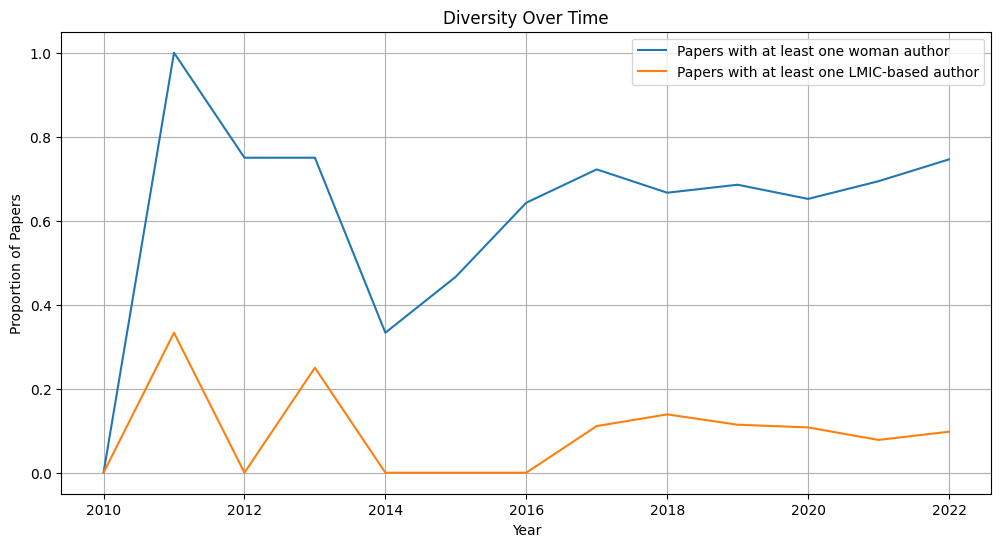

In [ ]:

# Create a 'has_woman' column indicating if a paper has at least one female author
MIMIC_affli['has_woman'] = (MIMIC_affli['gender'] == 'female').astype(int)

# Create a 'has_LMIC' column indicating if a paper has at least one LMIC author
MIMIC_affli['has_LMIC'] = (MIMIC_affli['LMIC'] == 'Yes').astype(int)  # Assuming 'Yes' and 'No' values for LMIC

# Group by year and paper_id
grouped_df = MIMIC_affli.groupby(['year', 'pub_id'])

# Calculate the metric for each paper: 
# If at least one author is a woman or from LMIC for a given paper
papers_diversity = grouped_df[['has_woman', 'has_LMIC']].max()
papers_diversity = papers_diversity.reset_index()

# Calculate the yearly average for each metric
yearly_woman_metric = papers_diversity.groupby('year')['has_woman'].mean()
yearly_LMIC_metric = papers_diversity.groupby('year')['has_LMIC'].mean()

# Plotting
plt.figure(figsize=(12,6))
yearly_woman_metric.plot(label='Papers with at least one woman author')
yearly_LMIC_metric.plot(label='Papers with at least one LMIC-based author')
plt.title('Diversity Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Papers')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Filter for the year 2011
df_2011 = MIMIC_affli[MIMIC_affli['year'] == 2011]

# Group by paper_id and check for female authors
grouped_2011 = df_2011.groupby('pub_id')['gender'].apply(lambda x: (x == 'female').any())

# Check the proportion of papers in 2011 with at least one female author
proportion_female_authors_2011 = grouped_2011.mean()

print(f"Proportion of papers in 2011 with at least one female author: {proportion_female_authors_2011:.2f}")
print("\nNumber of papers in 2011:", grouped_2011.size)
print("Number of papers with at least one female author:", grouped_2011.sum())


Proportion of papers in 2011 with at least one female author: 1.00

Number of papers in 2011: 3
Number of papers with at least one female author: 3


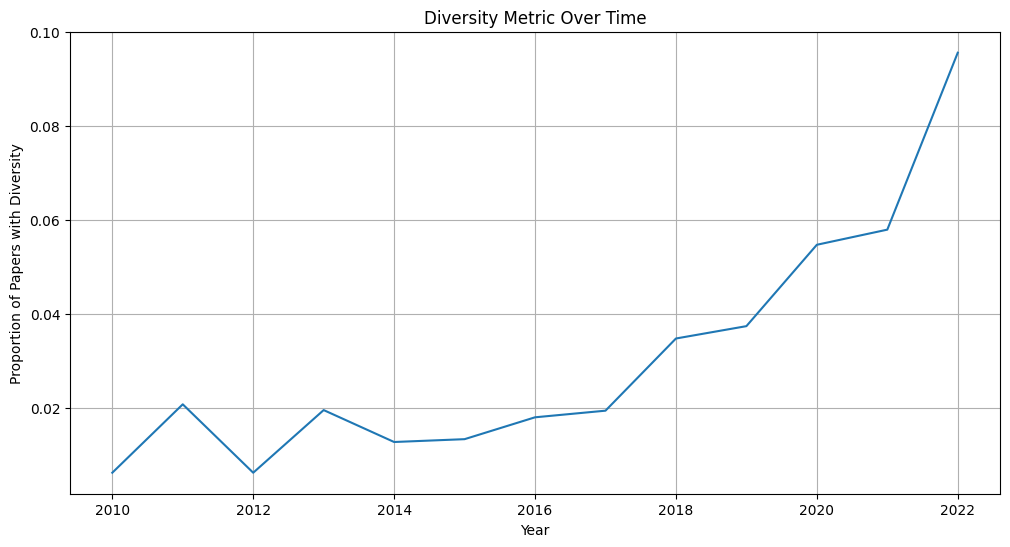

In [ ]:

# Create a 'has_woman' column indicating if a paper has at least one female author
Control_affli['has_woman'] = (Control_affli['gender'] == 'female').astype(int)

# Create a 'has_LMIC' column indicating if a paper has at least one LMIC author
Control_affli['has_LMIC'] = (Control_affli['LMIC'] == 'Yes').astype(int)  # Assuming 'Yes' and 'No' values for LMIC

# Group by year and paper_id, then calculate the diversity metric
grouped_df = Control_affli.groupby(['year', 'pub_id'])
diversity_metric = grouped_df[['has_woman', 'has_LMIC']].max()  # max function will ensure if at least one is present
diversity_metric = diversity_metric.reset_index()

# Now group by year and calculate the average metric
yearly_metric = diversity_metric.groupby('year').apply(lambda x: (x['has_woman'] & x['has_LMIC']).mean())

# Plotting
plt.figure(figsize=(12,6))
yearly_metric.plot()
plt.title('Control Diversity Metric Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Papers with Diversity')
plt.grid(True)
plt.show()
